<a href="https://colab.research.google.com/github/Shiwan-Fang/Ants-Vs.-SomeBees/blob/main/tw_predict_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, RepeatedStratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn import metrics

import keras
from keras import models, layers, Input, ops, initializers, optimizers
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.metrics import AUC

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import shap

In [ ]:
# set random seed
import os
import random
import numpy as np
import tensorflow as tf

# Fix random seed
tf.config.experimental.enable_op_determinism()
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Force TensorFlow to use deterministic ops
os.environ["TF_DETERMINISTIC_OPS"] = "1"


In [ ]:
python_version = !python --version
print(python_version)

['Python 3.11.12']


### Load the dataset

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! ls '/content/drive/MyDrive/Colab Notebooks/dataset'

1year.arff  3year.arff	5year.arff
2year.arff  4year.arff	taiwan_bankruptcy_data.csv


In [ ]:
file_path = '/content/drive/MyDrive/Colab Notebooks/dataset/taiwan_bankruptcy_data.csv'
# use the last year dataset
df = pd.read_csv(file_path)

In [ ]:
df.shape

(6819, 96)

In [ ]:
df.info()
# all float and int
# no missing value

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

In [ ]:
pd.set_option('display.max_columns', None)   # Show all columns
pd.set_option('display.width', None)          # Don't wrap lines
pd.set_option('display.max_colwidth', None)   # Full content in each cell
df.describe()
# from this table, there are a lot of features are rates whose value is between 0 and 1. in that case i think i don't need process it's outliers
# but for some features(e.g. Operating Expense Rate), its max value is 9.990000e+09, probably a missing value but was replaced by the huge number

Bankrupt?   ROA(C) before interest and depreciation before interest  \
count  6819.000000                                               6819.000000   
mean      0.032263                                                  0.505180   
std       0.176710                                                  0.060686   
min       0.000000                                                  0.000000   
25%       0.000000                                                  0.476527   
50%       0.000000                                                  0.502706   
75%       0.000000                                                  0.535563   
max       1.000000                                                  1.000000   

        ROA(A) before interest and % after tax  \
count                              6819.000000   
mean                                  0.558625   
std                                   0.065620   
min                                   0.000000   
25%                                   0.535543   
50%                                   0.559802   
75%                                   0.589157   
max                                   1.000000   

        ROA(B) before interest and depreciation after tax  \
count                                         6819.000000   
mean                                             0.553589   
std                                              0.061595   
min                                              0.000000   
25%                                              0.527277   
50%                                              0.552278   
75%                                              0.584105   
max                                              1.000000   

        Operating Gross Margin   Realized Sales Gross Margin  \
count              6819.000000                   6819.000000   
mean                  0.607948                      0.607929   
std                   0.016934                      0.016916   
min                   0.000000                      0.000000   
25%                   0.600445                      0.600434   
50%                   0.605997                      0.605976   
75%                   0.613914                      0.613842   
max                   1.000000                      1.000000   

        Operating Profit Rate   Pre-tax net Interest Rate  \
count             6819.000000                 6819.000000   
mean                 0.998755                    0.797190   
std                  0.013010                    0.012869   
min                  0.000000                    0.000000   
25%                  0.998969                    0.797386   
50%                  0.999022                    0.797464   
75%                  0.999095                    0.797579   
max                  1.000000                    1.000000   

        After-tax net Interest Rate  \
count                   6819.000000   
mean                       0.809084   
std                        0.013601   
min                        0.000000   
25%                        0.809312   
50%                        0.809375   
75%                        0.809469   
max                        1.000000   

        Non-industry income and expenditure/revenue  \
count                                   6819.000000   
mean                                       0.303623   
std                                        0.011163   
min                                        0.000000   
25%                                        0.303466   
50%                                        0.303525   
75%                                        0.303585   
max                                        1.000000   

        Continuous interest rate (after tax)   Operating Expense Rate  \
count                            6819.000000             6.819000e+03   
mean                                0.781381             1.995347e+09   
std                                 0.012679             3.237684e+09   
min                 

### EDA

#### binary class distribution

In [ ]:
df_eda = df.copy()

In [ ]:
df_eda.shape

(6819, 96)

In [ ]:
df_eda['Bankrupt?'].value_counts()

Bankrupt?
0    6599
1     220
Name: count, dtype: int64

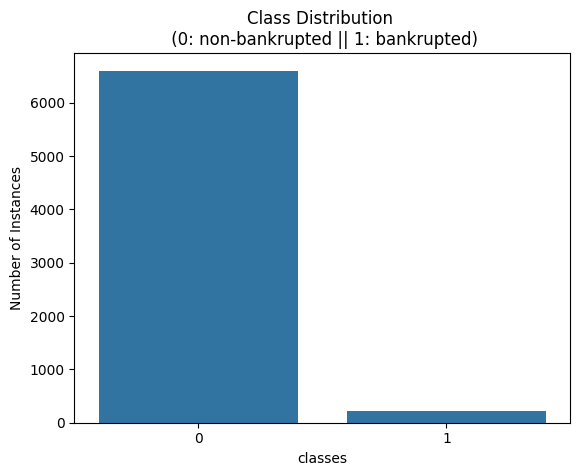

In [ ]:
sns.countplot(data=df_eda, x='Bankrupt?')
plt.title('Class Distribution \n (0: non-bankrupted || 1: bankrupted)')
plt.ylabel('Number of Instances')
plt.xlabel("classes")
plt.show()

#### missing value detection

In [ ]:
missing_percentage = df_eda.isnull().sum()
print(missing_percentage.sum())
# no missing value

0


#### PCA

In [ ]:
X_eda = df_eda.iloc[:, 0:]
y_eda = df_eda.iloc[:, 0]
print(y_eda)
print(X_eda.shape, y_eda.shape)

0       1
1       1
2       1
3       1
4       1
       ..
6814    0
6815    0
6816    0
6817    0
6818    0
Name: Bankrupt?, Length: 6819, dtype: int64
(6819, 96) (6819,)


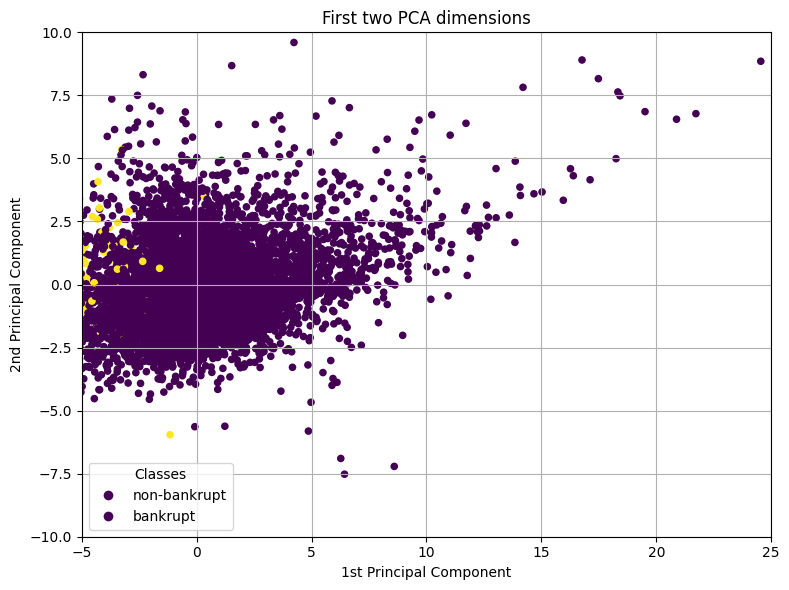

In [ ]:
# check the outliers
X_eda = df_eda.iloc[:, 0:]
y_eda = df_eda.iloc[:, 0]

scaler = StandardScaler()
X_eda_scaled = scaler.fit_transform(X_eda)

X_pca = PCA(n_components=2).fit_transform(X_eda_scaled)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_pca[:, 0],  # 1st principal component
    X_pca[:, 1],  # 2nd principal component
    c=y_eda,  # color by class
    s=20
)

# Labels
plt.title("First two PCA dimensions")
plt.xlabel("1st Principal Component")
plt.ylabel("2nd Principal Component")

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='non-bankrupt',
           markerfacecolor=plt.cm.viridis(0), markersize=8),
    Line2D([0], [0], marker='o', color='w', label='bankrupt',
           markerfacecolor=plt.cm.viridis(1), markersize=8)
]
plt.legend(handles=legend_elements, title="Classes")

plt.ylim([-10,10])
plt.xlim([-5, 25])


plt.grid(True)
plt.tight_layout()
plt.show()


#### T-SNE

In [ ]:
#tsne

# want to get TSNE embedding with 2 diemensions
n_components = 2
tsne = TSNE(n_components, perplexity=70) # tried 50
tsne_result = tsne.fit_transform(X_eda_scaled)
tsne_result.shape

(6819, 2)

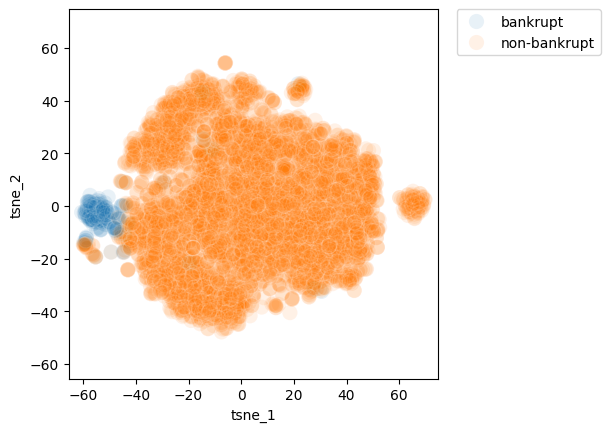

In [ ]:
#Plot the result of our TSNE with the label color coded
#A lot of the stuff here is about making the plot look pretty and not TSNE
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:, 0], 'tsne_2': tsne_result[:, 1], 'label': y_eda.map({0: 'non-bankrupt', 1: 'bankrupt'})})
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax, s=120, alpha=0.1)
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

#### boxplot

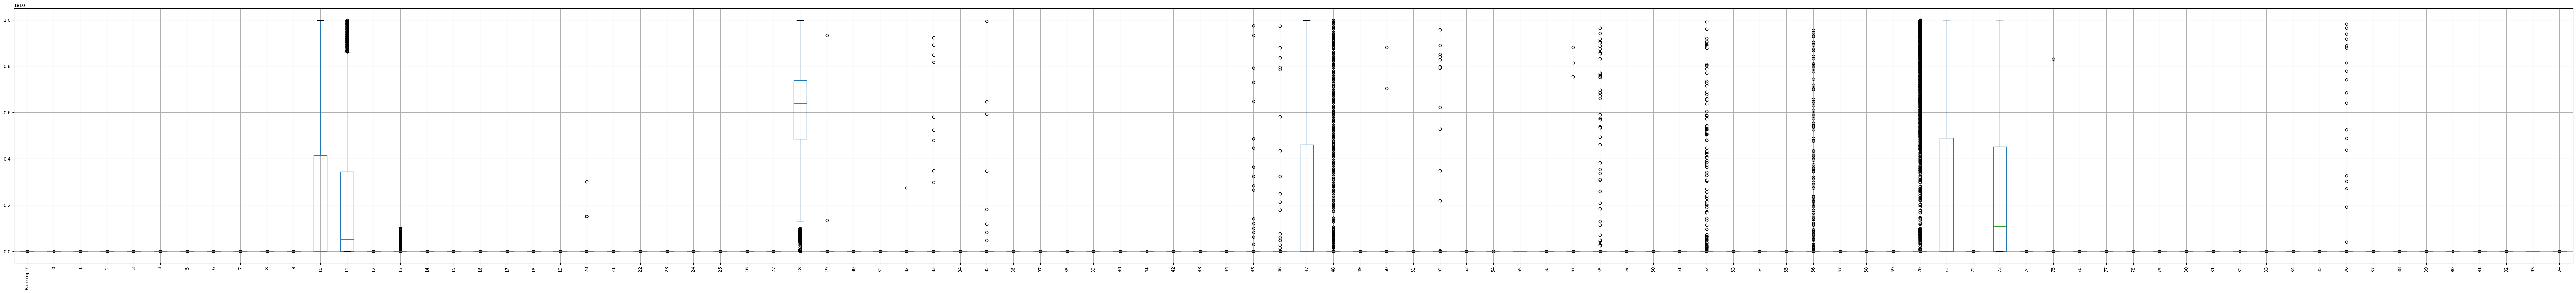

In [ ]:


df_eda_features = df_eda.iloc[:, 1:]

# Step 1: Create a mapping from numbers to original column names
col_mapping = {i: col for i, col in enumerate(df_eda_features.columns)}

# Step 2: Rename columns to numbers temporarily
df_eda_temp = df_eda.rename(columns={v: k for k, v in col_mapping.items()})

# Step 3: Plot boxplot
plt.figure(figsize=(100, 10))
boxplot = df_eda_temp.boxplot()
plt.xticks(rotation=90)  # Rotate numbers if necessary
plt.show()

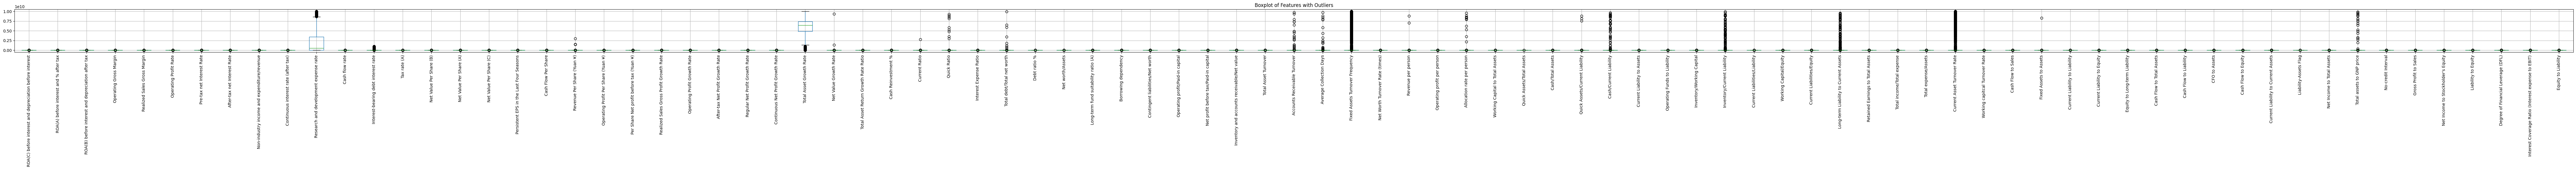

In [ ]:
# Identify features with outliers using the IQR method
def has_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return ((series < lower_bound) | (series > upper_bound)).any()

# Filter only features with outliers
features_with_outliers = [col for col in df_eda_features.columns if has_outliers(df_eda_features[col])]
df_outliers_only = df_eda_features[features_with_outliers]

# Plot boxplot of features with outliers
plt.figure(figsize=(max(12, len(features_with_outliers)), 6))
df_outliers_only.boxplot()
plt.xticks(rotation=90)
plt.title("Boxplot of Features with Outliers")
plt.tight_layout()
plt.show()

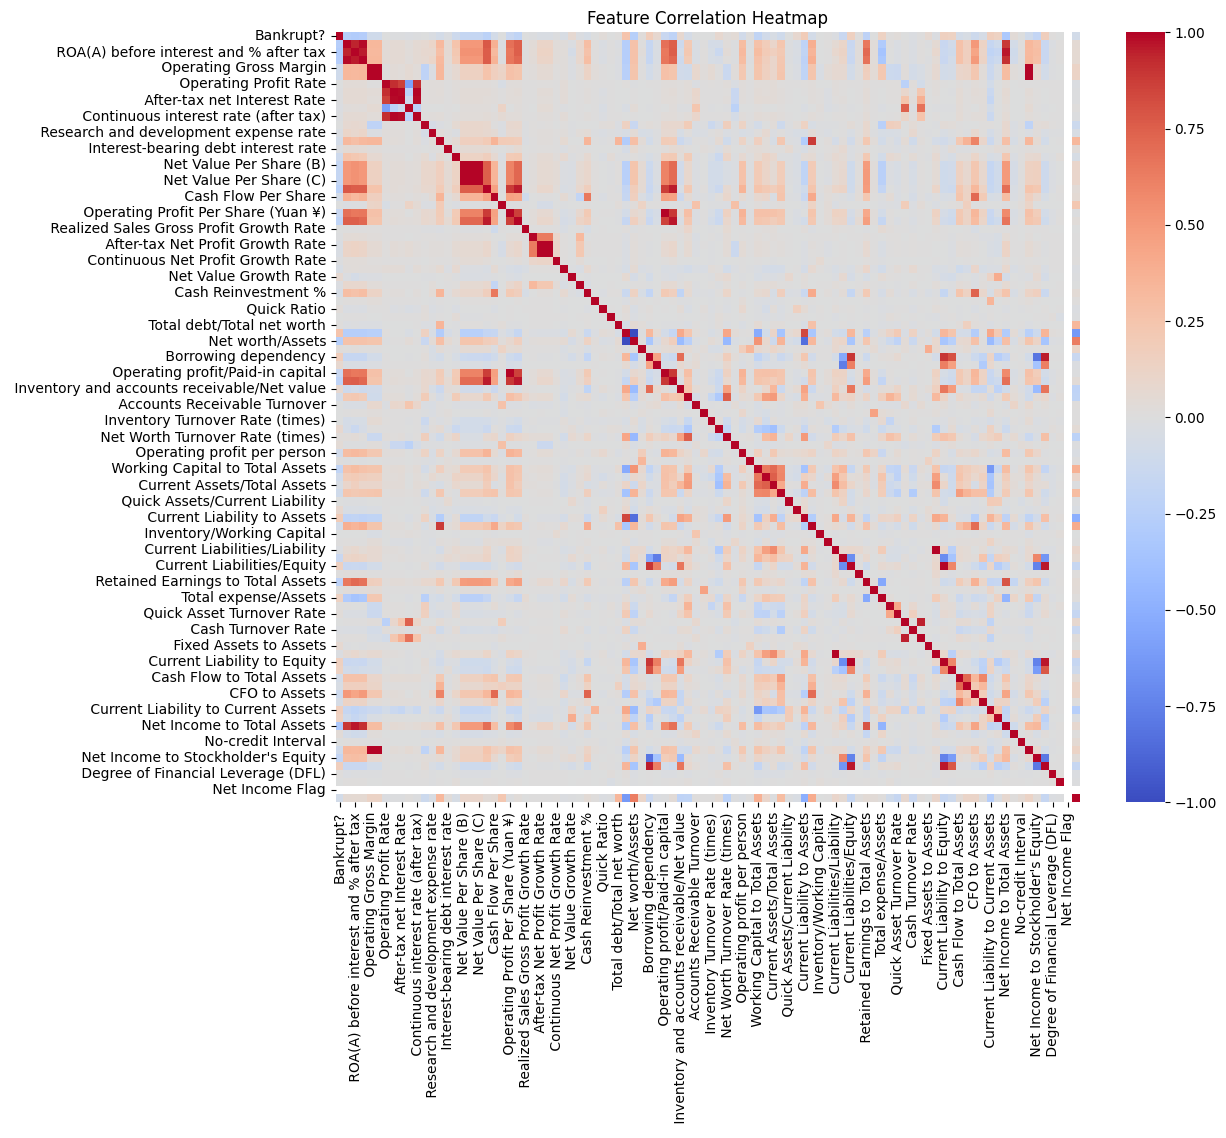

In [ ]:
corr_matrix = df_eda.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=False)
plt.title('Feature Correlation Heatmap')
plt.show()

### Data Preprocessing

In [ ]:
df_pre = df.copy()

In [ ]:
X_pre, y_pre = df_pre.drop('Bankrupt?', axis=1), df_pre['Bankrupt?']

In [ ]:
max_vals = X_pre.max()

# Step 2: Separate columns
rate_cols = max_vals[max_vals == 1].index.tolist() # likely rate or proportion columns
suspicious_cols = max_vals[max_vals > 1e5].index.tolist()  # suspiciously large max

# Step 3: Drop rate columns temporarily
X_pre_non_rate = X_pre.drop(columns=rate_cols)

# Step 4: Inspect suspicious columns
print("Columns with very large max values:")
print(max_vals.loc[suspicious_cols].sort_values(ascending=False))

# Optional: Look at the distribution of a few of them
df[suspicious_cols].describe().T

Columns with very large max values:
Cash Turnover Rate                       1.000000e+10
Current Asset Turnover Rate              1.000000e+10
Quick Asset Turnover Rate                1.000000e+10
Operating Expense Rate                   9.990000e+09
Inventory Turnover Rate (times)          9.990000e+09
Total Asset Growth Rate                  9.990000e+09
Fixed Assets Turnover Frequency          9.990000e+09
Research and development expense rate    9.980000e+09
Total debt/Total net worth               9.940000e+09
Inventory/Current Liability              9.910000e+09
Total assets to GNP price                9.820000e+09
Accounts Receivable Turnover             9.740000e+09
Average Collection Days                  9.730000e+09
Cash/Current Liability                   9.650000e+09
Allocation rate per person               9.570000e+09
Long-term Liability to Current Assets    9.540000e+09
Net Value Growth Rate                    9.330000e+09
Quick Ratio                              9.230

count          mean           std  \
Operating Expense Rate                 6819.0  1.995347e+09  3.237684e+09   
Research and development expense rate  6819.0  1.950427e+09  2.598292e+09   
Interest-bearing debt interest rate    6819.0  1.644801e+07  1.082750e+08   
Revenue Per Share (Yuan ¥)             6819.0  1.328641e+06  5.170709e+07   
Total Asset Growth Rate                6819.0  5.508097e+09  2.897718e+09   
Net Value Growth Rate                  6819.0  1.566212e+06  1.141594e+08   
Current Ratio                          6819.0  4.032850e+05  3.330216e+07   
Quick Ratio                            6819.0  8.376595e+06  2.446847e+08   
Total debt/Total net worth             6819.0  4.416337e+06  1.684069e+08   
Accounts Receivable Turnover           6819.0  1.278971e+07  2.782598e+08   
Average Collection Days                6819.0  9.826221e+06  2.563589e+08   
Inventory Turnover Rate (times)        6819.0  2.149106e+09  3.247967e+09   
Fixed Assets Turnover Frequency        6819.0  1.008596e+09  2.477557e+09   
Revenue per person                     6819.0  2.325854e+06  1.366327e+08   
Allocation rate per person             6819.0  1.125579e+07  2.945063e+08   
Quick Assets/Current Liability         6819.0  3.592902e+06  1.716209e+08   
Cash/Current Liability                 6819.0  3.715999e+07  5.103509e+08   
Inventory/Current Liability            6819.0  5.580680e+07  5.820516e+08   
Long-term Liability to Current Assets  6819.0  5.416004e+07  5.702706e+08   
Current Asset Turnover Rate            6819.0  1.195856e+09  2.821161e+09   
Quick Asset Turnover Rate              6819.0  2.163735e+09  3.374944e+09   
Cash Turnover Rate                     6819.0  2.471977e+09  2.938623e+09   
Fixed Assets to Assets                 6819.0  1.220121e+06  1.007542e+08   
Total assets to GNP price              6819.0  1.862942e+07  3.764501e+08   

                                       min           25%           50%  \
Operating Expense Rate                 0.0  1.566874e-04  2.777589e-04   
Research and development expense rate  0.0  1.281880e-04  5.090000e+08   
Interest-bearing debt interest rate    0.0  2.030203e-04  3.210321e-04   
Revenue Per Share (Yuan ¥)             0.0  1.563138e-02  2.737571e-02   
Total Asset Growth Rate                0.0  4.860000e+09  6.400000e+09   
Net Value Growth Rate                  0.0  4.409689e-04  4.619555e-04   
Current Ratio                          0.0  7.555047e-03  1.058717e-02   
Quick Ratio                            0.0  4.725903e-03  7.412472e-03   
Total debt/Total net worth             0.0  3.007049e-03  5.546284e-03   
Accounts Receivable Turnover           0.0  7.101336e-04  9.678107e-04   
Average Collection Days                0.0  4.386530e-03  6.572537e-03   
Inventory Turnover Rate (times)        0.0  1.728256e-04  7.646743e-04   
Fixed Assets Turnover Frequency        0.0  2.330013e-04  5.930942e-04   
Revenue per person                     0.0  1.043285e-02  1.861551e-02   
Allocation rate per person             0.0  4.120529e-03  7.844373e-03   
Quick Assets/Current Liability         0.0  5.239776e-03  7.908898e-03   
Cash/Current Liability                 0.0  1.973008e-03  4.903886e-03   
Inventory/Current Liability            0.0  3.163148e-03  6.497335e-03   
Long-term Liability to Current Assets  0.0  0.000000e+00  1.974619e-03   
Current Asset Turnover Rate            0.0  1.456236e-04  1.987816e-04   
Quick Asset Turnover Rate              0.0  1.417149e-04  2.247728e-04   
Cash Turnover Rate                     0.0  2.735337e-04  1.080000e+09   
Fixed Assets to Assets                 0.0  8.536037e-02  1.968810e-01   
Total assets to GNP price              0.0  9.036205e-04  2.085213e-03   

                                                75%           max  
Operating Expense Rate                 4.145000e+09  9.990000e+09  
Research and development expense rate  3.450000e+09  9.980000e+09  
Interest-bearing debt interest rate    5.325533e-04  9.9000

In [ ]:
from re import X
outlier_list = []
u = 0
for col in X_pre_non_rate.columns:
  q1 = df_pre[col].quantile(0.25)
  q3 = df_pre[col].quantile(0.75)
  iqr = q3 - q1
  lower_bound = q1 - 1.5 * iqr
  upper_bound = q3 + 1.5 * iqr
  outliers = df_pre[(df_pre[col] < lower_bound) | (df_pre[col] > upper_bound)]
  outlier_percentage = len(outliers) / len(df_pre) * 100
  outlier_list.append(outliers)
  print(f'{u} {col}: {outlier_percentage:.2f}%')
  u+=1
outlier_info = pd.concat(outlier_list, ignore_index=True).drop_duplicates().reset_index(drop=True)
outlier_info.shape


0  Operating Expense Rate: 0.00%
1  Research and development expense rate: 2.67%
2  Interest-bearing debt interest rate: 5.81%
3  Revenue Per Share (Yuan ¥): 7.01%
4  Total Asset Growth Rate: 20.25%
5  Net Value Growth Rate: 11.61%
6  Current Ratio: 8.64%
7  Quick Ratio: 8.67%
8  Total debt/Total net worth: 5.97%
9  Accounts Receivable Turnover: 9.66%
10  Average Collection Days: 2.83%
11  Inventory Turnover Rate (times): 0.00%
12  Fixed Assets Turnover Frequency: 20.79%
13  Revenue per person: 10.69%
14  Allocation rate per person: 10.16%
15  Quick Assets/Current Liability: 8.74%
16  Cash/Current Liability: 10.68%
17  Inventory/Current Liability: 6.25%
18  Long-term Liability to Current Assets: 9.09%
19  Current Asset Turnover Rate: 20.52%
20  Quick Asset Turnover Rate: 0.00%
21  Cash Turnover Rate: 0.00%
22  Fixed Assets to Assets: 0.91%
23  Total assets to GNP price: 11.69%


(5022, 96)

In [ ]:
df_pre = df_pre.drop(columns=suspicious_cols)
X_pre, y_pre = df_pre.drop('Bankrupt?', axis=1), df_pre['Bankrupt?']
df_pre.shape

(6819, 72)

### MLP + SMOTE + KD

#### distiller

In [ ]:
class Distiller(keras.Model):
  def __init__(self, student, teacher):
    super().__init__()
    self.teacher = teacher
    self.student = student

  def compile(
      self,
      optimizer,
      metrics,
      student_loss_fn,
      distillation_loss_fn,
      alpha=None,
      temperature=None
  ):
    super().compile(optimizer=optimizer, metrics=metrics)
    self.student_loss_fn = student_loss_fn
    self.distillation_loss_fn = distillation_loss_fn
    self.alpha = alpha
    self.temperature = temperature

  def train_step(self, data):
      x, (y_hard, y_soft) = data

      with tf.GradientTape() as tape:
          hard_pred, soft_pred = self.student(x, training=True)
          teacher_pred = self.teacher(x, training=False)

          # Compute losses
          hard_loss = self.student_loss_fn(y_hard, hard_pred)
          soft_loss = self.distillation_loss_fn(
              tf.nn.sigmoid(teacher_pred / self.temperature),
              tf.nn.sigmoid(soft_pred / self.temperature)
          ) * (self.temperature ** 2)

          loss = self.alpha * hard_loss + (1 - self.alpha) * soft_loss

      # Apply gradients
      grads = tape.gradient(loss, self.student.trainable_variables)
      self.optimizer.apply_gradients(zip(grads, self.student.trainable_variables))

      # Update metrics using hard_pred (final prediction)
      for metric in self.metrics:
          metric.update_state(y_hard, tf.nn.sigmoid(hard_pred))

      return {m.name: m.result() for m in self.metrics} | {"loss": loss}

  def test_step(self, data):
      x, (y_hard, _) = data  # Also unpack two labels for consistency
      hard_pred, _ = self.student(x, training=False)
      loss = self.student_loss_fn(y_hard, hard_pred)

      for metric in self.metrics:
          metric.update_state(y_hard, tf.nn.sigmoid(hard_pred))

      return {m.name: m.result() for m in self.metrics} | {"loss": loss}
  def call(self, inputs):
    return self.student(inputs)[0]  # only return hard_head

#### teacher & student model

In [ ]:
def teacher():
    # define the model
    model = models.Sequential(name='teacher')
    model.add(Input(shape=(X_pre.shape[1],)))
    # First input layer + repeated blocks
    for i in range(3):
        model.add(layers.Dense(128, activation='relu', kernel_initializer=initializers.GlorotUniform(seed=SEED)))          # Fully connected layer why chose relu https://machinelearningmastery.com/choose-an-activation-function-for-deep-learning/
        model.add(layers.BatchNormalization())                   # Batch normalization
        model.add(layers.Dropout(0.2, seed=SEED))

    # Output layer, choose sigmoid is bc it's a binary classification problem
    model.add(layers.Dense(1))


    return model


def student():
    inputs = keras.Input(shape=(X_pre.shape[1],))
    x = inputs
    for _ in range(3):
        x = layers.Dense(128, activation='relu', kernel_initializer=initializers.GlorotUniform(seed=SEED))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.2, seed=SEED)(x)

    # Two heads: one for hard, one for soft
    hard_output = layers.Dense(1, name='hard_head')(x)
    soft_output = layers.Dense(1, name='soft_head')(x)

    model = keras.Model(inputs=inputs, outputs=[hard_output, soft_output], name="student")
    return model

In [ ]:
import tensorflow as tf
class SigmoidAUC(tf.keras.metrics.AUC):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Apply sigmoid manually inside metric
        y_pred = tf.nn.sigmoid(y_pred)
        return super().update_state(y_true, y_pred, sample_weight=sample_weight)

#### skfold training

In [ ]:
class Skfold_Trainer:
  def __init__(self, teacher, X, y, mode, student=None, k=10, num_epochs=200, batch_size=16, verbosity=0, is_best_model=False, rus_test=False):
    # Directly pass the model instance instead of a model function
    self.teacher_template = keras.models.clone_model(teacher)
    self.teacher = None
    self.student_template = keras.models.clone_model(student) if student else None
    self.student = None
    self.X = X
    self.y = y
    self.k = k
    self.num_epochs = num_epochs
    self.batch_size = batch_size
    self.verbosity = verbosity
    self.early_stop = EarlyStopping(monitor='val_loss', patience=5, mode='min', min_delta=0.001, restore_best_weights=True)
    self.mode = mode
    self.is_best_model = is_best_model
    self.rus_test = rus_test

    self.val_loss = {"distiller": [],}
    self.val_roc_aucs = { "distiller": [],}
    self.val_pr_aucs = {"distiller": [],}

    self.loss = {"baseline":[], "teacher": [], "distiller": [],}
    self.roc_aucs = {"baseline":[], "teacher": [], "distiller": [],}
    self.pr_aucs = {"baseline":[], "teacher": [], "distiller": [],}

    self.shap_feature_importances = {"baseline":[], "teacher": [], "distiller": [],}

    self.confusion_metrics = {"baseline":[], "teacher": [], "distiller": [],}


  def train(self, alpha=None, temp=None):
    skfold = RepeatedStratifiedKFold(n_splits=self.k, n_repeats=2, random_state=SEED)
    fold_indices = list(skfold.split(self.X, self.y))

    for i in range(self.k*2):
        print(f'\n🔁 Fold {i+1}/{self.k*2} started...')
        train_val_idx, test_idx = fold_indices[i]

        # split train_val into training and validation
        train_idx, val_idx = train_test_split(
            train_val_idx,
            test_size=0.12,
            stratify=self.y.iloc[train_val_idx],
            random_state=SEED
        )

        X_train, y_train = self.X.iloc[train_idx], self.y.iloc[train_idx]
        X_val, y_val = self.X.iloc[val_idx], self.y.iloc[val_idx]
        X_test, y_test = self.X.iloc[test_idx], self.y.iloc[test_idx]

        # train the baseline / teacher model
        if self.mode in ['baseline', "teacher"]:
            if self.mode == 'teacher':
              if self.rus_test:
                print("🔄 Applying RUS...")
                rus = RandomUnderSampler(random_state=SEED)
                X_train, y_train = rus.fit_resample(X_train, y_train)
              else:
                print("🔄 Applying SMOTE...")
                smote = SMOTE(sampling_strategy=0.1,random_state=SEED)
                X_train, y_train = smote.fit_resample(X_train, y_train)

            self.teacher = keras.models.clone_model(self.teacher_template)
            self.teacher.compile(optimizer='adam',
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[SigmoidAUC(name='auc_roc', curve='ROC'),
                        SigmoidAUC(name='auc_pr', curve='PR')])

            history = self.teacher.fit(
                X_train, y_train,
                validation_data=(X_val, y_val),
                epochs=self.num_epochs,
                batch_size=self.batch_size,
                verbose=self.verbosity,
                callbacks=[self.early_stop]
            )

            print(f"Evaluate {self.mode} on training set...")
            train_loss, train_auc_roc, train_auc_pr = self.teacher.evaluate(X_train, y_train, verbose=self.verbosity)
            print(f'✅ Fold {i+1}: {self.mode} Train Loss={train_loss:.4f}, Train ROC AUC={train_auc_roc:.4f}, Train PR AUC={train_auc_pr:.4f}')

            print(f"Evaluate {self.mode} on test set...")
            self.evaluate_model(self.teacher, self.mode, X_test, y_test, i)


            #calculate shap
            self.evaluate_shap(self.teacher, self.mode, X_train, X_test)

            #calculate the confusion matrics
            y_pred = self.teacher.predict(X_test)
            y_pred_binary = (y_pred > 0.5).astype(int)
            cm = metrics.confusion_matrix(y_test, y_pred_binary)
            self.confusion_metrics[self.mode].append(cm)

        #train the student model
        elif self.mode == "distiller":
            if self.rus_test:
                print("🔄 Applying RUS...")
                rus = RandomUnderSampler(random_state=SEED)
                X_train, y_train = rus.fit_resample(X_train, y_train)
            else:
              print("🔄 Applying SMOTE...")
              smote = SMOTE(sampling_strategy=0.1,random_state=SEED)
              X_train, y_train = smote.fit_resample(X_train, y_train)

            self.teacher = keras.models.clone_model(self.teacher_template)
            self.teacher.compile(optimizer='adam',
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[SigmoidAUC(name='auc_roc', curve='ROC'),
                        SigmoidAUC(name='auc_pr', curve='PR')])

            self.teacher.fit(
                X_train, y_train,
                validation_data=(X_val, y_val),
                epochs=self.num_epochs,
                batch_size=self.batch_size,
                verbose=self.verbosity,
                callbacks=[self.early_stop]
            )

            #overfitting test
            print("Evaluate teacher on training set...")
            train_loss, train_auc_roc, train_auc_pr = self.teacher.evaluate(X_train, y_train, verbose=self.verbosity)
            print(f'✅ Fold {i+1}: Teacher Train Loss={train_loss:.4f}, Train ROC AUC={train_auc_roc:.4f}, Train PR AUC={train_auc_pr:.4f}')

            print("Evaluate teacher on test set...")
            self.evaluate_model(self.teacher,'teacher', X_test, y_test, i)

            self.student = keras.models.clone_model(self.student_template)
            distiller = Distiller(student=self.student, teacher=self.teacher)

            distiller.compile(
                optimizer=keras.optimizers.Adam(),
                metrics=[SigmoidAUC(name='auc_roc', curve='ROC'), SigmoidAUC(name='auc_pr', curve='PR')],
                student_loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
                distillation_loss_fn=keras.losses.KLDivergence(),
                alpha=alpha,
                temperature=temp,
            )

            distiller.fit(
                X_train, [y_train, y_train],
                validation_data=(X_val, [y_val, y_val]),
                epochs=self.num_epochs,
                batch_size=self.batch_size,
                verbose=self.verbosity,
                callbacks=[self.early_stop]
            )

            val_loss, val_metrics = distiller.evaluate(X_val, [y_val, y_val], verbose=self.verbosity)
            self.val_roc_aucs['distiller'].append(val_metrics["auc_roc"].numpy())
            self.val_pr_aucs['distiller'].append(val_metrics["auc_pr"].numpy())

            print("Evaluate distiller on training set...")
            distiller_loss, distiller_metrics = distiller.evaluate(X_train, [y_train, y_train], verbose=self.verbosity)
            distiller_auc_roc, distiller_auc_pr = distiller_metrics["auc_roc"].numpy(), distiller_metrics["auc_pr"].numpy()
            print(f'✅ Fold {i+1}: {self.mode} Training Loss={distiller_loss:.4f}, Training ROC AUC={distiller_auc_roc:.4f}, Training PR AUC={distiller_auc_pr:.4f}')

            print("Evaluate distiller on test set...")
            self.evaluate_model(distiller, 'distiller', X_test, [y_test,y_test], i)
            if self.is_best_model:
              #apply shap
              self.evaluate_shap(distiller, self.mode, X_train, X_test)

              #apply confusion matrix
              y_pred = distiller.predict(X_test)
              y_pred_binary = (y_pred > 0.5).astype(int)
              cm = metrics.confusion_matrix(y_test, y_pred_binary)
              self.confusion_metrics[self.mode].append(cm)

    print('average roc auc on the testing set')
    print({key: sum(values)/len(values) if values else None for key, values in self.roc_aucs.items()})
    print('average pr auc on the testing set')
    print({key: sum(values)/len(values) if values else None for key, values in self.pr_aucs.items()})

    print('the standard deviation on test set')
    print(f'SD of {self.mode}\'s roc-auc: {np.std(self.roc_aucs[self.mode])}, SD of {self.mode}\'s pr-auc: {np.std(self.pr_aucs[self.mode])}')

    print('Average Confusion Matrices in testing set:')
    for mode in ["baseline", "teacher", "distiller"]:
      cms = self.confusion_metrics[mode]
      if cms:
          avg_cm = sum(cms) / len(cms)
          print(f"\n🧪 {mode} - Average Confusion Matrix:\n{avg_cm}")
          cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=avg_cm.astype(int), display_labels=[0, 1])
          cm_display.plot()
          plt.title(f"{mode} - Average Confusion Matrix")
          plt.show()


  def evaluate_model(self, model, mode_name, X_test, y_test, fold):
    if mode_name in ['teacher', 'baseline']:
      test_loss, test_auc_roc, test_auc_pr = model.evaluate(X_test, y_test, verbose=self.verbosity)
      print(f'✅ Fold {fold+1}: {mode_name} Test Loss={test_loss:.4f}, Test ROC AUC={test_auc_roc:.4f}, Test PR AUC={test_auc_pr:.4f}')
      self.loss[mode_name].append(test_loss)
      self.roc_aucs[mode_name].append(test_auc_roc)
      self.pr_aucs[mode_name].append(test_auc_pr)
    elif mode_name == 'distiller':
      test_loss, test_metrics = model.evaluate(X_test, y_test, verbose=self.verbosity)
      self.loss[mode_name].append(test_loss.numpy())
      self.roc_aucs[mode_name].append(float(test_metrics["auc_roc"].numpy()))
      self.pr_aucs[mode_name].append(float(test_metrics["auc_pr"].numpy()))
      print(f'✅ Fold {fold+1}: {mode_name} Test Loss={test_loss.numpy():.4f}, Test ROC AUC={test_metrics["auc_roc"].numpy():.4f}, Test PR AUC={test_metrics["auc_pr"].numpy():.4f}')



  def evaluate_shap(self, model, mode_name,X_train, X_explain_df):
    X_train = X_train.to_numpy()
    X_explain = X_explain_df.to_numpy()
    background = shap.utils.sample(X_train, random_state=SEED)
    explain_data = X_explain[:100]

    predict_fn = lambda x: tf.nn.sigmoid(model(x)).numpy()
    explainer = shap.KernelExplainer(predict_fn, background)
    shap_values = explainer.shap_values(explain_data)

    if isinstance(shap_values, list):
        shap_values = shap_values[0]

    # ✅ Save mean SHAP importance per feature for this fold
    mean_shap = np.mean(np.abs(shap_values), axis=0)
    self.shap_feature_importances[mode_name].append(mean_shap)

    print("✅ SHAP vector saved for fold. Shape:", mean_shap.shape)

  def compute_shap_stability(self, mode_name):
    from sklearn.metrics.pairwise import cosine_similarity
    from itertools import combinations

    shap_vectors = self.shap_feature_importances[mode_name]

    similarities = []
    for v1, v2 in combinations(shap_vectors, 2):
        sim = cosine_similarity(v1.reshape(1, -1), v2.reshape(1, -1))[0][0]
        similarities.append(sim)

    sim_M = np.mean(similarities)
    return f"📊 SHAP Stability (sim_M) for {mode_name}: {sim_M:.4f}"
    # return sim_M

#### grid search

In [ ]:
def grid_search(X, y, teacher, student, mode="distiller", alphas=None, temps=None, is_best_model=False):
    best_auc_pr = 0
    best_setting = None

    for alpha in alphas:
      for temp in temps:
          print(f"\n=== Trying alpha={alpha}, temperature={temp} ===")
          trainer = Skfold_Trainer(teacher=teacher, student=student, X=X, y=y, mode=mode, is_best_model=is_best_model)
          trainer.train(alpha=alpha, temp=temp)
          # use PR AUC as my key selection metric
          print(trainer.val_pr_aucs["distiller"])
          avg_auc_pr = np.mean(trainer.val_pr_aucs["distiller"])
          print(f"Average Val PR AUC: {avg_auc_pr:.4f}")

          if avg_auc_pr > best_auc_pr:
              best_auc_pr = avg_auc_pr
              best_setting = (alpha, temp)

    if is_best_model:
      trainer.compute_shap_stability(mode)

    print(f"\n Best Setting: alpha={best_setting[0]}, temperature={best_setting[1]}, AUC PR={best_auc_pr:.4f}")
    return best_setting

### result: baseline and teacher model


🔁 Fold 1/20 started...
Evaluate baseline on training set...
✅ Fold 1: baseline Train Loss=0.0863, Train ROC AUC=0.9399, Train PR AUC=0.4656
Evaluate baseline on test set...
✅ Fold 1: baseline Test Loss=0.1264, Test ROC AUC=0.8634, Test PR AUC=0.2717


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

🔁 Fold 2/20 started...
Evaluate baseline on training set...
✅ Fold 2: baseline Train Loss=0.1000, Train ROC AUC=0.9200, Train PR AUC=0.3664
Evaluate baseline on test set...
✅ Fold 2: baseline Test Loss=0.1096, Test ROC AUC=0.9290, Test PR AUC=0.3107


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 3/20 started...
Evaluate baseline on training set...
✅ Fold 3: baseline Train Loss=0.0915, Train ROC AUC=0.9322, Train PR AUC=0.4105
Evaluate baseline on test set...
✅ Fold 3: baseline Test Loss=0.0989, Test ROC AUC=0.9037, Test PR AUC=0.3582


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

🔁 Fold 4/20 started...
Evaluate baseline on training set...
✅ Fold 4: baseline Train Loss=0.0995, Train ROC AUC=0.9242, Train PR AUC=0.3861
Evaluate baseline on test set...
✅ Fold 4: baseline Test Loss=0.0913, Test ROC AUC=0.9557, Test PR AUC=0.4595


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 5/20 started...
Evaluate baseline on training set...
✅ Fold 5: baseline Train Loss=0.0891, Train ROC AUC=0.9387, Train PR AUC=0.4124
Evaluate baseline on test set...
✅ Fold 5: baseline Test Loss=0.1191, Test ROC AUC=0.9422, Test PR AUC=0.3621


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

🔁 Fold 6/20 started...
Evaluate baseline on training set...
✅ Fold 6: baseline Train Loss=0.1090, Train ROC AUC=0.8973, Train PR AUC=0.3449
Evaluate baseline on test set...
✅ Fold 6: baseline Test Loss=0.1181, Test ROC AUC=0.8717, Test PR AUC=0.2617


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 7/20 started...
Evaluate baseline on training set...
✅ Fold 7: baseline Train Loss=0.0882, Train ROC AUC=0.9423, Train PR AUC=0.4275
Evaluate baseline on test set...
✅ Fold 7: baseline Test Loss=0.0867, Test ROC AUC=0.9473, Test PR AUC=0.4632


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 8/20 started...
Evaluate baseline on training set...
✅ Fold 8: baseline Train Loss=0.0877, Train ROC AUC=0.9449, Train PR AUC=0.4319
Evaluate baseline on test set...
✅ Fold 8: baseline Test Loss=0.1092, Test ROC AUC=0.7987, Test PR AUC=0.3951


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 9/20 started...
Evaluate baseline on training set...
✅ Fold 9: baseline Train Loss=0.0917, Train ROC AUC=0.9339, Train PR AUC=0.4301
Evaluate baseline on test set...
✅ Fold 9: baseline Test Loss=0.1083, Test ROC AUC=0.8785, Test PR AUC=0.3113


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 10/20 started...
Evaluate baseline on training set...
✅ Fold 10: baseline Train Loss=0.1043, Train ROC AUC=0.8966, Train PR AUC=0.3034
Evaluate baseline on test set...
✅ Fold 10: baseline Test Loss=0.0952, Test ROC AUC=0.9262, Test PR AUC=0.3289


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

🔁 Fold 11/20 started...
Evaluate baseline on training set...
✅ Fold 11: baseline Train Loss=0.0908, Train ROC AUC=0.9475, Train PR AUC=0.4315
Evaluate baseline on test set...
✅ Fold 11: baseline Test Loss=0.1062, Test ROC AUC=0.9081, Test PR AUC=0.3327


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

🔁 Fold 12/20 started...
Evaluate baseline on training set...
✅ Fold 12: baseline Train Loss=0.0883, Train ROC AUC=0.9403, Train PR AUC=0.4097
Evaluate baseline on test set...
✅ Fold 12: baseline Test Loss=0.1127, Test ROC AUC=0.9381, Test PR AUC=0.4340


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 13/20 started...
Evaluate baseline on training set...
✅ Fold 13: baseline Train Loss=0.0947, Train ROC AUC=0.9380, Train PR AUC=0.4096
Evaluate baseline on test set...
✅ Fold 13: baseline Test Loss=0.1002, Test ROC AUC=0.9313, Test PR AUC=0.3513


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 14/20 started...
Evaluate baseline on training set...
✅ Fold 14: baseline Train Loss=0.0905, Train ROC AUC=0.9363, Train PR AUC=0.4206
Evaluate baseline on test set...
✅ Fold 14: baseline Test Loss=0.0929, Test ROC AUC=0.9382, Test PR AUC=0.3618


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 15/20 started...
Evaluate baseline on training set...
✅ Fold 15: baseline Train Loss=0.0938, Train ROC AUC=0.9328, Train PR AUC=0.4085
Evaluate baseline on test set...
✅ Fold 15: baseline Test Loss=0.0969, Test ROC AUC=0.9437, Test PR AUC=0.3712


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

🔁 Fold 16/20 started...
Evaluate baseline on training set...
✅ Fold 16: baseline Train Loss=0.0993, Train ROC AUC=0.9245, Train PR AUC=0.3819
Evaluate baseline on test set...
✅ Fold 16: baseline Test Loss=0.1005, Test ROC AUC=0.9257, Test PR AUC=0.4360


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 17/20 started...
Evaluate baseline on training set...
✅ Fold 17: baseline Train Loss=0.0925, Train ROC AUC=0.9349, Train PR AUC=0.4399
Evaluate baseline on test set...
✅ Fold 17: baseline Test Loss=0.1011, Test ROC AUC=0.9268, Test PR AUC=0.3693


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 18/20 started...
Evaluate baseline on training set...
✅ Fold 18: baseline Train Loss=0.1006, Train ROC AUC=0.9314, Train PR AUC=0.3988
Evaluate baseline on test set...
✅ Fold 18: baseline Test Loss=0.1235, Test ROC AUC=0.8623, Test PR AUC=0.1920


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

🔁 Fold 19/20 started...
Evaluate baseline on training set...
✅ Fold 19: baseline Train Loss=0.0929, Train ROC AUC=0.9393, Train PR AUC=0.4230
Evaluate baseline on test set...
✅ Fold 19: baseline Test Loss=0.0820, Test ROC AUC=0.9384, Test PR AUC=0.5103


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 20/20 started...
Evaluate baseline on training set...
✅ Fold 20: baseline Train Loss=0.0972, Train ROC AUC=0.9385, Train PR AUC=0.3904
Evaluate baseline on test set...
✅ Fold 20: baseline Test Loss=0.1045, Test ROC AUC=0.8653, Test PR AUC=0.3634


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
average roc auc on the testing set
{'baseline': 0.9097138971090317, 'teacher': None, 'distiller': None}
average pr auc on the testing set
{'baseline': 0.3622192904353142, 'teacher': None, 'distiller': None}
the standard deviation on test set
SD of baseline's roc-auc: 0.03936473636683833, SD of baseline's pr-auc: 0.0735030323560843
Average Confusion Matrices in testing set:

🧪 baseline - Average Confusion Matrix:
[[657.35   2.55]
 [ 18.8    3.2 ]]


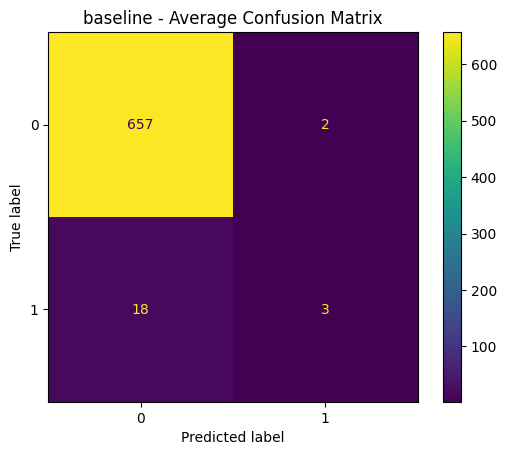

'📊 SHAP Stability (sim_M) for baseline: 0.7705'

In [ ]:
#baseline
teacher = teacher()
teacher_skfold_trainer = Skfold_Trainer(mode='baseline', teacher=teacher, student=None, X=X_pre, y=y_pre)
teacher_skfold_trainer.train()
teacher_skfold_trainer.compute_shap_stability("baseline")


🔁 Fold 1/20 started...
🔄 Applying SMOTE...
Evaluate teacher on training set...
✅ Fold 1: teacher Train Loss=0.1571, Train ROC AUC=0.9643, Train PR AUC=0.7261
Evaluate teacher on test set...
✅ Fold 1: teacher Test Loss=0.1057, Test ROC AUC=0.8951, Test PR AUC=0.2844


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

🔁 Fold 2/20 started...
🔄 Applying SMOTE...
Evaluate teacher on training set...
✅ Fold 2: teacher Train Loss=0.1723, Train ROC AUC=0.9407, Train PR AUC=0.6009
Evaluate teacher on test set...
✅ Fold 2: teacher Test Loss=0.1315, Test ROC AUC=0.9289, Test PR AUC=0.2941


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

🔁 Fold 3/20 started...
🔄 Applying SMOTE...
Evaluate teacher on training set...
✅ Fold 3: teacher Train Loss=0.2194, Train ROC AUC=0.9231, Train PR AUC=0.6029
Evaluate teacher on test set...
✅ Fold 3: teacher Test Loss=0.1043, Test ROC AUC=0.8694, Test PR AUC=0.2750


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 4/20 started...
🔄 Applying SMOTE...
Evaluate teacher on training set...
✅ Fold 4: teacher Train Loss=0.1506, Train ROC AUC=0.9515, Train PR AUC=0.6953
Evaluate teacher on test set...
✅ Fold 4: teacher Test Loss=0.0910, Test ROC AUC=0.9484, Test PR AUC=0.4756


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

🔁 Fold 5/20 started...
🔄 Applying SMOTE...
Evaluate teacher on training set...
✅ Fold 5: teacher Train Loss=0.1685, Train ROC AUC=0.9454, Train PR AUC=0.6559
Evaluate teacher on test set...
✅ Fold 5: teacher Test Loss=0.1046, Test ROC AUC=0.9542, Test PR AUC=0.3715


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 6/20 started...
🔄 Applying SMOTE...
Evaluate teacher on training set...
✅ Fold 6: teacher Train Loss=0.1953, Train ROC AUC=0.9433, Train PR AUC=0.6495
Evaluate teacher on test set...
✅ Fold 6: teacher Test Loss=0.1065, Test ROC AUC=0.8519, Test PR AUC=0.3204


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 7/20 started...
🔄 Applying SMOTE...
Evaluate teacher on training set...
✅ Fold 7: teacher Train Loss=0.1885, Train ROC AUC=0.9375, Train PR AUC=0.6398
Evaluate teacher on test set...
✅ Fold 7: teacher Test Loss=0.0943, Test ROC AUC=0.9090, Test PR AUC=0.4001


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 8/20 started...
🔄 Applying SMOTE...
Evaluate teacher on training set...
✅ Fold 8: teacher Train Loss=0.1758, Train ROC AUC=0.9465, Train PR AUC=0.6293
Evaluate teacher on test set...
✅ Fold 8: teacher Test Loss=0.1330, Test ROC AUC=0.8486, Test PR AUC=0.4636


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 9/20 started...
🔄 Applying SMOTE...
Evaluate teacher on training set...
✅ Fold 9: teacher Train Loss=0.1595, Train ROC AUC=0.9526, Train PR AUC=0.7132
Evaluate teacher on test set...
✅ Fold 9: teacher Test Loss=0.0834, Test ROC AUC=0.9488, Test PR AUC=0.4720


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 10/20 started...
🔄 Applying SMOTE...
Evaluate teacher on training set...
✅ Fold 10: teacher Train Loss=0.1632, Train ROC AUC=0.9506, Train PR AUC=0.6685
Evaluate teacher on test set...
✅ Fold 10: teacher Test Loss=0.0853, Test ROC AUC=0.9552, Test PR AUC=0.4452


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

🔁 Fold 11/20 started...
🔄 Applying SMOTE...
Evaluate teacher on training set...
✅ Fold 11: teacher Train Loss=0.1714, Train ROC AUC=0.9503, Train PR AUC=0.6576
Evaluate teacher on test set...
✅ Fold 11: teacher Test Loss=0.1052, Test ROC AUC=0.8752, Test PR AUC=0.2994


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 12/20 started...
🔄 Applying SMOTE...
Evaluate teacher on training set...
✅ Fold 12: teacher Train Loss=0.1710, Train ROC AUC=0.9478, Train PR AUC=0.6435
Evaluate teacher on test set...
✅ Fold 12: teacher Test Loss=0.1085, Test ROC AUC=0.9450, Test PR AUC=0.3528


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

🔁 Fold 13/20 started...
🔄 Applying SMOTE...
Evaluate teacher on training set...
✅ Fold 13: teacher Train Loss=0.1682, Train ROC AUC=0.9579, Train PR AUC=0.7166
Evaluate teacher on test set...
✅ Fold 13: teacher Test Loss=0.0897, Test ROC AUC=0.9129, Test PR AUC=0.4185


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

🔁 Fold 14/20 started...
🔄 Applying SMOTE...
Evaluate teacher on training set...
✅ Fold 14: teacher Train Loss=0.1819, Train ROC AUC=0.9278, Train PR AUC=0.6229
Evaluate teacher on test set...
✅ Fold 14: teacher Test Loss=0.0969, Test ROC AUC=0.9092, Test PR AUC=0.3718


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

🔁 Fold 15/20 started...
🔄 Applying SMOTE...
Evaluate teacher on training set...
✅ Fold 15: teacher Train Loss=0.2006, Train ROC AUC=0.9264, Train PR AUC=0.6217
Evaluate teacher on test set...
✅ Fold 15: teacher Test Loss=0.1034, Test ROC AUC=0.8703, Test PR AUC=0.3754


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

🔁 Fold 16/20 started...
🔄 Applying SMOTE...
Evaluate teacher on training set...
✅ Fold 16: teacher Train Loss=0.1963, Train ROC AUC=0.9396, Train PR AUC=0.6078
Evaluate teacher on test set...
✅ Fold 16: teacher Test Loss=0.0947, Test ROC AUC=0.9236, Test PR AUC=0.4574


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

🔁 Fold 17/20 started...
🔄 Applying SMOTE...
Evaluate teacher on training set...
✅ Fold 17: teacher Train Loss=0.1901, Train ROC AUC=0.9547, Train PR AUC=0.7257
Evaluate teacher on test set...
✅ Fold 17: teacher Test Loss=0.1045, Test ROC AUC=0.8925, Test PR AUC=0.3536


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

🔁 Fold 18/20 started...
🔄 Applying SMOTE...
Evaluate teacher on training set...
✅ Fold 18: teacher Train Loss=0.2164, Train ROC AUC=0.9381, Train PR AUC=0.6970
Evaluate teacher on test set...
✅ Fold 18: teacher Test Loss=0.1362, Test ROC AUC=0.8071, Test PR AUC=0.1870


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

🔁 Fold 19/20 started...
🔄 Applying SMOTE...
Evaluate teacher on training set...
✅ Fold 19: teacher Train Loss=0.1656, Train ROC AUC=0.9485, Train PR AUC=0.6524
Evaluate teacher on test set...
✅ Fold 19: teacher Test Loss=0.0992, Test ROC AUC=0.9316, Test PR AUC=0.4713


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

🔁 Fold 20/20 started...
🔄 Applying SMOTE...
Evaluate teacher on training set...
✅ Fold 20: teacher Train Loss=0.1940, Train ROC AUC=0.9320, Train PR AUC=0.5901
Evaluate teacher on test set...
✅ Fold 20: teacher Test Loss=0.1052, Test ROC AUC=0.8726, Test PR AUC=0.3336


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
average roc auc on the testing set
{'baseline': None, 'teacher': 0.9024852216243744, 'distiller': None}
average pr auc on the testing set
{'baseline': None, 'teacher': 0.371135912835598, 'distiller': None}
the standard deviation on test set
SD of teacher's roc-auc: 0.04011721413269137, SD of teacher's pr-auc: 0.07813396431290644
Average Confusion Matrices in testing set:

🧪 teacher - Average Confusion Matrix:
[[656.85   3.05]
 [ 18.55   3.45]]


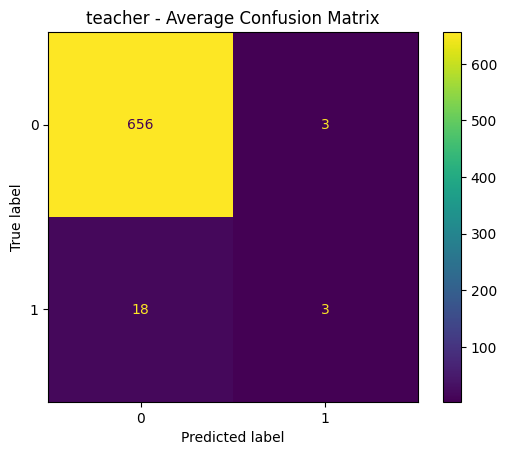

'📊 SHAP Stability (sim_M) for teacher: 0.7803'

In [ ]:
#teacher model
teacher = teacher()
ts_skfold_trainer = Skfold_Trainer(mode='teacher',teacher=teacher, student=None, X=X_pre, y=y_pre)
ts_skfold_trainer.train()
ts_skfold_trainer.compute_shap_stability("teacher")

### result: knowledge distillation

In [ ]:
def teacher():
    # define the model
    model = models.Sequential(name='teacher')
    model.add(Input(shape=(X_pre.shape[1],)))
    # First input layer + repeated blocks
    for i in range(3):
        model.add(layers.Dense(128, activation='relu', kernel_initializer=initializers.GlorotUniform(seed=SEED)))          # Fully connected layer why chose relu https://machinelearningmastery.com/choose-an-activation-function-for-deep-learning/
        model.add(layers.BatchNormalization())                   # Batch normalization
        model.add(layers.Dropout(0.2, seed=SEED))

    # Output layer, choose sigmoid is bc it's a binary classification problem
    model.add(layers.Dense(1))


    return model


def student():
    inputs = keras.Input(shape=(X_pre.shape[1],))
    x = inputs
    for _ in range(3):
        x = layers.Dense(128, activation='relu', kernel_initializer=initializers.GlorotUniform(seed=SEED))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.2, seed=SEED)(x)

    # Two heads: one for hard, one for soft
    hard_output = layers.Dense(1, name='hard_head')(x)
    soft_output = layers.Dense(1, name='soft_head')(x)

    model = keras.Model(inputs=inputs, outputs=[hard_output, soft_output], name="student")
    return model

teacher = teacher()
student = student()
best_alpha_temp = grid_search(
    X=X_pre,
    y=y_pre,
    teacher=teacher,
    student=student,
    alphas=[0.3, 0.5, 0.7, 0.9],
    temps=[3, 5, 7, 9]
)



=== Trying alpha=0.3, temperature=3 ===

🔁 Fold 1/20 started...
🔄 Applying SMOTE...
Evaluate teacher on training set...
✅ Fold 1: Teacher Train Loss=0.1752, Train ROC AUC=0.9617, Train PR AUC=0.6891
Evaluate teacher on test set...
✅ Fold 1: teacher Test Loss=0.1063, Test ROC AUC=0.8909, Test PR AUC=0.2841
Evaluate distiller on training set...
✅ Fold 1: distiller Training Loss=2.4432, Training ROC AUC=0.8726, Training PR AUC=0.5182
Evaluate distiller on test set...
✅ Fold 1: distiller Test Loss=0.0467, Test ROC AUC=0.8245, Test PR AUC=0.2490

🔁 Fold 2/20 started...
🔄 Applying SMOTE...
Evaluate teacher on training set...
✅ Fold 2: Teacher Train Loss=0.1653, Train ROC AUC=0.9421, Train PR AUC=0.6246
Evaluate teacher on test set...
✅ Fold 2: teacher Test Loss=0.1174, Test ROC AUC=0.9417, Test PR AUC=0.3914
Evaluate distiller on training set...
✅ Fold 2: distiller Training Loss=0.4003, Training ROC AUC=0.9412, Training PR AUC=0.6453
Evaluate distiller on test set...
✅ Fold 2: distiller Tes

In [ ]:
def teacher():
    # define the model
    model = models.Sequential(name='teacher')
    model.add(Input(shape=(X_pre.shape[1],)))
    # First input layer + repeated blocks
    for i in range(3):
        model.add(layers.Dense(128, activation='relu', kernel_initializer=initializers.GlorotUniform(seed=SEED)))          # Fully connected layer why chose relu https://machinelearningmastery.com/choose-an-activation-function-for-deep-learning/
        model.add(layers.BatchNormalization())                   # Batch normalization
        model.add(layers.Dropout(0.2, seed=SEED))

    # Output layer, choose sigmoid is bc it's a binary classification problem
    model.add(layers.Dense(1))


    return model


def student():
    inputs = keras.Input(shape=(X_pre.shape[1],))
    x = inputs
    for _ in range(3):
        x = layers.Dense(128, activation='relu', kernel_initializer=initializers.GlorotUniform(seed=SEED))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.2, seed=SEED)(x)

    # Two heads: one for hard, one for soft
    hard_output = layers.Dense(1, name='hard_head')(x)
    soft_output = layers.Dense(1, name='soft_head')(x)

    model = keras.Model(inputs=inputs, outputs=[hard_output, soft_output], name="student")
    return model

teacher = teacher()
student = student()
best_alpha_temp = grid_search(
    X=X_pre,
    y=y_pre,
    teacher=teacher,
    student=student,
    alphas=[0.3],
    temps=[3, 5, 7, 9]
)


=== Trying alpha=0.3, temperature=3 ===

🔁 Fold 1/20 started...
🔄 Applying SMOTE...
Evaluate teacher on training set...
✅ Fold 1: Teacher Train Loss=0.1752, Train ROC AUC=0.9617, Train PR AUC=0.6891
Evaluate teacher on test set...
✅ Fold 1: teacher Test Loss=0.1063, Test ROC AUC=0.8909, Test PR AUC=0.2841
Evaluate distiller on training set...
✅ Fold 1: distiller Training Loss=2.4432, Training ROC AUC=0.8726, Training PR AUC=0.5182
Evaluate distiller on test set...
✅ Fold 1: distiller Test Loss=0.0467, Test ROC AUC=0.8245, Test PR AUC=0.2490

🔁 Fold 2/20 started...
🔄 Applying SMOTE...
Evaluate teacher on training set...
✅ Fold 2: Teacher Train Loss=0.1653, Train ROC AUC=0.9421, Train PR AUC=0.6246
Evaluate teacher on test set...
✅ Fold 2: teacher Test Loss=0.1174, Test ROC AUC=0.9417, Test PR AUC=0.3914
Evaluate distiller on training set...
✅ Fold 2: distiller Training Loss=0.4003, Training ROC AUC=0.9412, Training PR AUC=0.6453
Evaluate distiller on test set...
✅ Fold 2: distiller Tes

In [ ]:
def teacher():
    # define the model
    model = models.Sequential(name='teacher')
    model.add(Input(shape=(X_pre.shape[1],)))
    # First input layer + repeated blocks
    for i in range(3):
        model.add(layers.Dense(128, activation='relu', kernel_initializer=initializers.GlorotUniform(seed=SEED)))          # Fully connected layer why chose relu https://machinelearningmastery.com/choose-an-activation-function-for-deep-learning/
        model.add(layers.BatchNormalization())                   # Batch normalization
        model.add(layers.Dropout(0.2, seed=SEED))

    # Output layer, choose sigmoid is bc it's a binary classification problem
    model.add(layers.Dense(1))


    return model


def student():
    inputs = keras.Input(shape=(X_pre.shape[1],))
    x = inputs
    for _ in range(3):
        x = layers.Dense(128, activation='relu', kernel_initializer=initializers.GlorotUniform(seed=SEED))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.2, seed=SEED)(x)

    # Two heads: one for hard, one for soft
    hard_output = layers.Dense(1, name='hard_head')(x)
    soft_output = layers.Dense(1, name='soft_head')(x)

    model = keras.Model(inputs=inputs, outputs=[hard_output, soft_output], name="student")
    return model

teacher = teacher()
student = student()
best_alpha_temp = grid_search(
    X=X_pre,
    y=y_pre,
    teacher=teacher,
    student=student,
    alphas=[0.5],
    temps=[3, 5, 7, 9]
)


=== Trying alpha=0.5, temperature=3 ===

🔁 Fold 1/20 started...
🔄 Applying SMOTE...
Evaluate teacher on training set...
✅ Fold 1: Teacher Train Loss=0.1508, Train ROC AUC=0.9651, Train PR AUC=0.7114
Evaluate teacher on test set...
✅ Fold 1: teacher Test Loss=0.1110, Test ROC AUC=0.8915, Test PR AUC=0.3003
Evaluate distiller on training set...
✅ Fold 1: distiller Training Loss=2.6742, Training ROC AUC=0.8743, Training PR AUC=0.5224
Evaluate distiller on test set...
✅ Fold 1: distiller Test Loss=0.0336, Test ROC AUC=0.7797, Test PR AUC=0.2602

🔁 Fold 2/20 started...
🔄 Applying SMOTE...
Evaluate teacher on training set...
✅ Fold 2: Teacher Train Loss=0.3212, Train ROC AUC=0.8301, Train PR AUC=0.4028
Evaluate teacher on test set...
✅ Fold 2: teacher Test Loss=0.1268, Test ROC AUC=0.7880, Test PR AUC=0.2229
Evaluate distiller on training set...
✅ Fold 2: distiller Training Loss=0.7124, Training ROC AUC=0.9450, Training PR AUC=0.6471
Evaluate distiller on test set...
✅ Fold 2: distiller Tes

In [ ]:
def teacher():
    # define the model
    model = models.Sequential(name='teacher')
    model.add(Input(shape=(X_pre.shape[1],)))
    # First input layer + repeated blocks
    for i in range(3):
        model.add(layers.Dense(128, activation='relu', kernel_initializer=initializers.GlorotUniform(seed=SEED)))          # Fully connected layer why chose relu https://machinelearningmastery.com/choose-an-activation-function-for-deep-learning/
        model.add(layers.BatchNormalization())                   # Batch normalization
        model.add(layers.Dropout(0.2, seed=SEED))

    # Output layer, choose sigmoid is bc it's a binary classification problem
    model.add(layers.Dense(1))


    return model


def student():
    inputs = keras.Input(shape=(X_pre.shape[1],))
    x = inputs
    for _ in range(3):
        x = layers.Dense(128, activation='relu', kernel_initializer=initializers.GlorotUniform(seed=SEED))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.2, seed=SEED)(x)

    # Two heads: one for hard, one for soft
    hard_output = layers.Dense(1, name='hard_head')(x)
    soft_output = layers.Dense(1, name='soft_head')(x)

    model = keras.Model(inputs=inputs, outputs=[hard_output, soft_output], name="student")
    return model

teacher = teacher()
student = student()
best_alpha_temp = grid_search(
    X=X_pre,
    y=y_pre,
    teacher=teacher,
    student=student,
    alphas=[0.7],
    temps=[3, 5, 7, 9]
)


=== Trying alpha=0.7, temperature=3 ===

🔁 Fold 1/20 started...
🔄 Applying SMOTE...
Evaluate teacher on training set...
✅ Fold 1: Teacher Train Loss=0.1992, Train ROC AUC=0.9479, Train PR AUC=0.6356
Evaluate teacher on test set...
✅ Fold 1: teacher Test Loss=0.1083, Test ROC AUC=0.8793, Test PR AUC=0.3000
Evaluate distiller on training set...
✅ Fold 1: distiller Training Loss=3.4468, Training ROC AUC=0.6872, Training PR AUC=0.3320
Evaluate distiller on test set...
✅ Fold 1: distiller Test Loss=0.0159, Test ROC AUC=0.6586, Test PR AUC=0.1921

🔁 Fold 2/20 started...
🔄 Applying SMOTE...
Evaluate teacher on training set...
✅ Fold 2: Teacher Train Loss=0.2609, Train ROC AUC=0.8623, Train PR AUC=0.4596
Evaluate teacher on test set...
✅ Fold 2: teacher Test Loss=0.1158, Test ROC AUC=0.9124, Test PR AUC=0.3597
Evaluate distiller on training set...
✅ Fold 2: distiller Training Loss=2.3553, Training ROC AUC=0.9252, Training PR AUC=0.6185
Evaluate distiller on test set...
✅ Fold 2: distiller Tes

In [ ]:
def teacher():
    # define the model
    model = models.Sequential(name='teacher')
    model.add(Input(shape=(X_pre.shape[1],)))
    # First input layer + repeated blocks
    for i in range(3):
        model.add(layers.Dense(128, activation='relu', kernel_initializer=initializers.GlorotUniform(seed=SEED)))          # Fully connected layer why chose relu https://machinelearningmastery.com/choose-an-activation-function-for-deep-learning/
        model.add(layers.BatchNormalization())                   # Batch normalization
        model.add(layers.Dropout(0.2, seed=SEED))

    # Output layer, choose sigmoid is bc it's a binary classification problem
    model.add(layers.Dense(1))


    return model


def student():
    inputs = keras.Input(shape=(X_pre.shape[1],))
    x = inputs
    for _ in range(3):
        x = layers.Dense(128, activation='relu', kernel_initializer=initializers.GlorotUniform(seed=SEED))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.2, seed=SEED)(x)

    # Two heads: one for hard, one for soft
    hard_output = layers.Dense(1, name='hard_head')(x)
    soft_output = layers.Dense(1, name='soft_head')(x)

    model = keras.Model(inputs=inputs, outputs=[hard_output, soft_output], name="student")
    return model

teacher = teacher()
student = student()
best_alpha_temp = grid_search(
    X=X_pre,
    y=y_pre,
    teacher=teacher,
    student=student,
    alphas=[0.9],
    temps=[3, 5, 7, 9]
)


=== Trying alpha=0.9, temperature=3 ===

🔁 Fold 1/20 started...
🔄 Applying SMOTE...
Evaluate teacher on training set...
✅ Fold 1: Teacher Train Loss=0.1752, Train ROC AUC=0.9617, Train PR AUC=0.6891
Evaluate teacher on test set...
✅ Fold 1: teacher Test Loss=0.1063, Test ROC AUC=0.8909, Test PR AUC=0.2841
Evaluate distiller on training set...
✅ Fold 1: distiller Training Loss=3.1448, Training ROC AUC=0.8198, Training PR AUC=0.4595
Evaluate distiller on test set...
✅ Fold 1: distiller Test Loss=0.0232, Test ROC AUC=0.7863, Test PR AUC=0.2449

🔁 Fold 2/20 started...
🔄 Applying SMOTE...
Evaluate teacher on training set...
✅ Fold 2: Teacher Train Loss=0.1653, Train ROC AUC=0.9421, Train PR AUC=0.6246
Evaluate teacher on test set...
✅ Fold 2: teacher Test Loss=0.1174, Test ROC AUC=0.9417, Test PR AUC=0.3914
Evaluate distiller on training set...
✅ Fold 2: distiller Training Loss=1.6118, Training ROC AUC=0.9601, Training PR AUC=0.6982
Evaluate distiller on test set...
✅ Fold 2: distiller Tes


🔁 Fold 1/20 started...
🔄 Applying SMOTE...
Evaluate teacher on training set...
✅ Fold 1: Teacher Train Loss=0.1542, Train ROC AUC=0.9643, Train PR AUC=0.7133
Evaluate teacher on test set...
✅ Fold 1: teacher Test Loss=0.1093, Test ROC AUC=0.8928, Test PR AUC=0.2956
Evaluate distiller on training set...
✅ Fold 1: distiller Training Loss=3.1667, Training ROC AUC=0.7441, Training PR AUC=0.3143
Evaluate distiller on test set...
✅ Fold 1: distiller Test Loss=0.0337, Test ROC AUC=0.6768, Test PR AUC=0.1652


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

🔁 Fold 2/20 started...
🔄 Applying SMOTE...
Evaluate teacher on training set...
✅ Fold 2: Teacher Train Loss=0.1693, Train ROC AUC=0.9437, Train PR AUC=0.6328
Evaluate teacher on test set...
✅ Fold 2: teacher Test Loss=0.1182, Test ROC AUC=0.9500, Test PR AUC=0.4028
Evaluate distiller on training set...
✅ Fold 2: distiller Training Loss=1.2093, Training ROC AUC=0.9439, Training PR AUC=0.6307
Evaluate distiller on test set...
✅ Fold 2: distiller Test Loss=0.1001, Test ROC AUC=0.9521, Test PR AUC=0.4047


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 3/20 started...
🔄 Applying SMOTE...
Evaluate teacher on training set...
✅ Fold 3: Teacher Train Loss=0.1915, Train ROC AUC=0.9460, Train PR AUC=0.6328
Evaluate teacher on test set...
✅ Fold 3: teacher Test Loss=0.0981, Test ROC AUC=0.9053, Test PR AUC=0.2930
Evaluate distiller on training set...
✅ Fold 3: distiller Training Loss=1.1263, Training ROC AUC=0.9497, Training PR AUC=0.6506
Evaluate distiller on test set...
✅ Fold 3: distiller Test Loss=0.0528, Test ROC AUC=0.9025, Test PR AUC=0.2928


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

🔁 Fold 4/20 started...
🔄 Applying SMOTE...
Evaluate teacher on training set...
✅ Fold 4: Teacher Train Loss=0.1634, Train ROC AUC=0.9510, Train PR AUC=0.6728
Evaluate teacher on test set...
✅ Fold 4: teacher Test Loss=0.0874, Test ROC AUC=0.9507, Test PR AUC=0.4724
Evaluate distiller on training set...
✅ Fold 4: distiller Training Loss=2.0521, Training ROC AUC=0.9383, Training PR AUC=0.6400
Evaluate distiller on test set...
✅ Fold 4: distiller Test Loss=0.0081, Test ROC AUC=0.9550, Test PR AUC=0.4444


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

🔁 Fold 5/20 started...
🔄 Applying SMOTE...
Evaluate teacher on training set...
✅ Fold 5: Teacher Train Loss=0.1625, Train ROC AUC=0.9516, Train PR AUC=0.6792
Evaluate teacher on test set...
✅ Fold 5: teacher Test Loss=0.1013, Test ROC AUC=0.9480, Test PR AUC=0.3627
Evaluate distiller on training set...
✅ Fold 5: distiller Training Loss=2.7622, Training ROC AUC=0.9245, Training PR AUC=0.6345
Evaluate distiller on test set...
✅ Fold 5: distiller Test Loss=0.0031, Test ROC AUC=0.9350, Test PR AUC=0.3682


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

🔁 Fold 6/20 started...
🔄 Applying SMOTE...
Evaluate teacher on training set...
✅ Fold 6: Teacher Train Loss=0.2012, Train ROC AUC=0.9378, Train PR AUC=0.6465
Evaluate teacher on test set...
✅ Fold 6: teacher Test Loss=0.1157, Test ROC AUC=0.8472, Test PR AUC=0.3163
Evaluate distiller on training set...
✅ Fold 6: distiller Training Loss=2.5437, Training ROC AUC=0.8889, Training PR AUC=0.5321
Evaluate distiller on test set...
✅ Fold 6: distiller Test Loss=0.0250, Test ROC AUC=0.7603, Test PR AUC=0.3256


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 7/20 started...
🔄 Applying SMOTE...
Evaluate teacher on training set...
✅ Fold 7: Teacher Train Loss=0.1665, Train ROC AUC=0.9427, Train PR AUC=0.6520
Evaluate teacher on test set...
✅ Fold 7: teacher Test Loss=0.0859, Test ROC AUC=0.9171, Test PR AUC=0.4845
Evaluate distiller on training set...
✅ Fold 7: distiller Training Loss=3.1144, Training ROC AUC=0.7991, Training PR AUC=0.4426
Evaluate distiller on test set...
✅ Fold 7: distiller Test Loss=0.0181, Test ROC AUC=0.8038, Test PR AUC=0.3051


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

🔁 Fold 8/20 started...
🔄 Applying SMOTE...
Evaluate teacher on training set...
✅ Fold 8: Teacher Train Loss=0.1710, Train ROC AUC=0.9522, Train PR AUC=0.6312
Evaluate teacher on test set...
✅ Fold 8: teacher Test Loss=0.1092, Test ROC AUC=0.8566, Test PR AUC=0.3801
Evaluate distiller on training set...
✅ Fold 8: distiller Training Loss=1.1519, Training ROC AUC=0.9464, Training PR AUC=0.6299
Evaluate distiller on test set...
✅ Fold 8: distiller Test Loss=0.0337, Test ROC AUC=0.8428, Test PR AUC=0.3990


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 9/20 started...
🔄 Applying SMOTE...
Evaluate teacher on training set...
✅ Fold 9: Teacher Train Loss=0.2092, Train ROC AUC=0.9172, Train PR AUC=0.6205
Evaluate teacher on test set...
✅ Fold 9: teacher Test Loss=0.0944, Test ROC AUC=0.9630, Test PR AUC=0.4344
Evaluate distiller on training set...
✅ Fold 9: distiller Training Loss=0.8516, Training ROC AUC=0.9287, Training PR AUC=0.6031
Evaluate distiller on test set...
✅ Fold 9: distiller Test Loss=0.0752, Test ROC AUC=0.9254, Test PR AUC=0.3902


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 10/20 started...
🔄 Applying SMOTE...
Evaluate teacher on training set...
✅ Fold 10: Teacher Train Loss=0.1915, Train ROC AUC=0.9291, Train PR AUC=0.5882
Evaluate teacher on test set...
✅ Fold 10: teacher Test Loss=0.1038, Test ROC AUC=0.9299, Test PR AUC=0.3628
Evaluate distiller on training set...
✅ Fold 10: distiller Training Loss=1.5654, Training ROC AUC=0.9346, Training PR AUC=0.5932
Evaluate distiller on test set...
✅ Fold 10: distiller Test Loss=0.0084, Test ROC AUC=0.9601, Test PR AUC=0.4399


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 11/20 started...
🔄 Applying SMOTE...
Evaluate teacher on training set...
✅ Fold 11: Teacher Train Loss=0.1734, Train ROC AUC=0.9499, Train PR AUC=0.6457
Evaluate teacher on test set...
✅ Fold 11: teacher Test Loss=0.0996, Test ROC AUC=0.8906, Test PR AUC=0.3496
Evaluate distiller on training set...
✅ Fold 11: distiller Training Loss=2.3805, Training ROC AUC=0.9084, Training PR AUC=0.5541
Evaluate distiller on test set...
✅ Fold 11: distiller Test Loss=0.0341, Test ROC AUC=0.8942, Test PR AUC=0.2882


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 12/20 started...
🔄 Applying SMOTE...
Evaluate teacher on training set...
✅ Fold 12: Teacher Train Loss=0.1886, Train ROC AUC=0.9459, Train PR AUC=0.6622
Evaluate teacher on test set...
✅ Fold 12: teacher Test Loss=0.0960, Test ROC AUC=0.9289, Test PR AUC=0.3364
Evaluate distiller on training set...
✅ Fold 12: distiller Training Loss=2.7333, Training ROC AUC=0.9252, Training PR AUC=0.6113
Evaluate distiller on test set...
✅ Fold 12: distiller Test Loss=0.0126, Test ROC AUC=0.9167, Test PR AUC=0.3546


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

🔁 Fold 13/20 started...
🔄 Applying SMOTE...
Evaluate teacher on training set...
✅ Fold 13: Teacher Train Loss=0.1674, Train ROC AUC=0.9554, Train PR AUC=0.6825
Evaluate teacher on test set...
✅ Fold 13: teacher Test Loss=0.0929, Test ROC AUC=0.9274, Test PR AUC=0.3749
Evaluate distiller on training set...
✅ Fold 13: distiller Training Loss=0.9789, Training ROC AUC=0.9438, Training PR AUC=0.6365
Evaluate distiller on test set...
✅ Fold 13: distiller Test Loss=0.0113, Test ROC AUC=0.9370, Test PR AUC=0.3526


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 14/20 started...
🔄 Applying SMOTE...
Evaluate teacher on training set...
✅ Fold 14: Teacher Train Loss=0.1684, Train ROC AUC=0.9438, Train PR AUC=0.6614
Evaluate teacher on test set...
✅ Fold 14: teacher Test Loss=0.0967, Test ROC AUC=0.9137, Test PR AUC=0.3597
Evaluate distiller on training set...
✅ Fold 14: distiller Training Loss=1.5875, Training ROC AUC=0.9395, Training PR AUC=0.6681
Evaluate distiller on test set...
✅ Fold 14: distiller Test Loss=0.0090, Test ROC AUC=0.9332, Test PR AUC=0.4050


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 15/20 started...
🔄 Applying SMOTE...
Evaluate teacher on training set...
✅ Fold 15: Teacher Train Loss=0.2522, Train ROC AUC=0.8961, Train PR AUC=0.5794
Evaluate teacher on test set...
✅ Fold 15: teacher Test Loss=0.1291, Test ROC AUC=0.8659, Test PR AUC=0.3499
Evaluate distiller on training set...
✅ Fold 15: distiller Training Loss=1.2651, Training ROC AUC=0.9441, Training PR AUC=0.6679
Evaluate distiller on test set...
✅ Fold 15: distiller Test Loss=0.0359, Test ROC AUC=0.9019, Test PR AUC=0.3409


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

🔁 Fold 16/20 started...
🔄 Applying SMOTE...
Evaluate teacher on training set...
✅ Fold 16: Teacher Train Loss=0.1867, Train ROC AUC=0.9480, Train PR AUC=0.6763
Evaluate teacher on test set...
✅ Fold 16: teacher Test Loss=0.0930, Test ROC AUC=0.9287, Test PR AUC=0.4514
Evaluate distiller on training set...
✅ Fold 16: distiller Training Loss=1.3369, Training ROC AUC=0.9352, Training PR AUC=0.6210
Evaluate distiller on test set...
✅ Fold 16: distiller Test Loss=0.0148, Test ROC AUC=0.9251, Test PR AUC=0.4734


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 17/20 started...
🔄 Applying SMOTE...
Evaluate teacher on training set...
✅ Fold 17: Teacher Train Loss=0.2618, Train ROC AUC=0.9082, Train PR AUC=0.5666
Evaluate teacher on test set...
✅ Fold 17: teacher Test Loss=0.1182, Test ROC AUC=0.8973, Test PR AUC=0.4158
Evaluate distiller on training set...
✅ Fold 17: distiller Training Loss=2.0062, Training ROC AUC=0.9502, Training PR AUC=0.6770
Evaluate distiller on test set...
✅ Fold 17: distiller Test Loss=0.0238, Test ROC AUC=0.9213, Test PR AUC=0.3676


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 18/20 started...
🔄 Applying SMOTE...
Evaluate teacher on training set...
✅ Fold 18: Teacher Train Loss=0.2192, Train ROC AUC=0.9393, Train PR AUC=0.6263
Evaluate teacher on test set...
✅ Fold 18: teacher Test Loss=0.1241, Test ROC AUC=0.9173, Test PR AUC=0.2251
Evaluate distiller on training set...
✅ Fold 18: distiller Training Loss=3.0327, Training ROC AUC=0.8768, Training PR AUC=0.5535
Evaluate distiller on test set...
✅ Fold 18: distiller Test Loss=0.0204, Test ROC AUC=0.8290, Test PR AUC=0.1797


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

🔁 Fold 19/20 started...
🔄 Applying SMOTE...
Evaluate teacher on training set...
✅ Fold 19: Teacher Train Loss=0.2044, Train ROC AUC=0.9396, Train PR AUC=0.6115
Evaluate teacher on test set...
✅ Fold 19: teacher Test Loss=0.0788, Test ROC AUC=0.9533, Test PR AUC=0.5003
Evaluate distiller on training set...
✅ Fold 19: distiller Training Loss=2.0436, Training ROC AUC=0.9206, Training PR AUC=0.5787
Evaluate distiller on test set...
✅ Fold 19: distiller Test Loss=0.0198, Test ROC AUC=0.9412, Test PR AUC=0.4579


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 20/20 started...
🔄 Applying SMOTE...
Evaluate teacher on training set...
✅ Fold 20: Teacher Train Loss=0.1765, Train ROC AUC=0.9532, Train PR AUC=0.6742
Evaluate teacher on test set...
✅ Fold 20: teacher Test Loss=0.1015, Test ROC AUC=0.8718, Test PR AUC=0.4140
Evaluate distiller on training set...
✅ Fold 20: distiller Training Loss=1.4365, Training ROC AUC=0.9451, Training PR AUC=0.6568
Evaluate distiller on test set...
✅ Fold 20: distiller Test Loss=0.0648, Test ROC AUC=0.8646, Test PR AUC=0.3853


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
average roc auc on the testing set
{'baseline': None, 'teacher': 0.9127742290496826, 'distiller': 0.8888985812664032}
average pr auc on the testing set
{'baseline': None, 'teacher': 0.3790866009891033, 'distiller': 0.35701650828123094}
the standard deviation on test set
SD of distiller's roc-auc: 0.0715880299667761, SD of distiller's pr-auc: 0.07992704506575633
Average Confusion Matrices in testing set:

🧪 distiller - Average Confusion Matrix:
[[657.1   2.8]
 [ 18.8   3.2]]


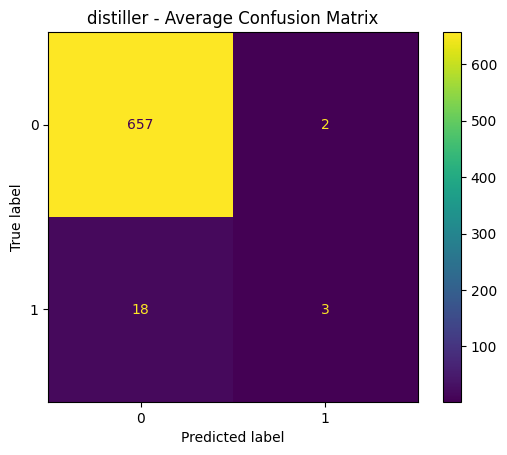

'📊 SHAP Stability (sim_M) for distiller: 0.7525'

In [ ]:
# train the model again with the best parameters to get shap and confusion matrix

teacher = teacher()
student = student()
teacher_skfold_trainer = Skfold_Trainer(mode='distiller', teacher=teacher, student=student, X=X_pre, y=y_pre, is_best_model=True)
teacher_skfold_trainer.train(alpha=0.7, temp=7)
teacher_skfold_trainer.compute_shap_stability("distiller")

### try smote sampling stragty with 0.5


=== Trying alpha=0.7, temperature=7 ===

🔁 Fold 1/20 started...
🔄 Applying SMOTE...
Evaluate teacher on training set...
✅ Fold 1: Teacher Train Loss=0.6764, Train ROC AUC=0.9559, Train PR AUC=0.8906
Evaluate teacher on test set...
✅ Fold 1: teacher Test Loss=0.1102, Test ROC AUC=0.8793, Test PR AUC=0.2532
Evaluate distiller on training set...
✅ Fold 1: distiller Training Loss=5.3090, Training ROC AUC=0.7390, Training PR AUC=0.7090
Evaluate distiller on test set...
✅ Fold 1: distiller Test Loss=0.0001, Test ROC AUC=0.7317, Test PR AUC=0.2221


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 2/20 started...
🔄 Applying SMOTE...
Evaluate teacher on training set...
✅ Fold 2: Teacher Train Loss=0.5623, Train ROC AUC=0.9560, Train PR AUC=0.9015
Evaluate teacher on test set...
✅ Fold 2: teacher Test Loss=0.1002, Test ROC AUC=0.9469, Test PR AUC=0.3629
Evaluate distiller on training set...
✅ Fold 2: distiller Training Loss=1.0075, Training ROC AUC=0.9564, Training PR AUC=0.8955
Evaluate distiller on test set...
✅ Fold 2: distiller Test Loss=0.0541, Test ROC AUC=0.9559, Test PR AUC=0.4063


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 3/20 started...
🔄 Applying SMOTE...
Evaluate teacher on training set...
✅ Fold 3: Teacher Train Loss=0.4300, Train ROC AUC=0.9488, Train PR AUC=0.8828
Evaluate teacher on test set...
✅ Fold 3: teacher Test Loss=0.1100, Test ROC AUC=0.8795, Test PR AUC=0.3915
Evaluate distiller on training set...
✅ Fold 3: distiller Training Loss=0.7499, Training ROC AUC=0.9527, Training PR AUC=0.8849
Evaluate distiller on test set...
✅ Fold 3: distiller Test Loss=0.1370, Test ROC AUC=0.9083, Test PR AUC=0.3384


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 4/20 started...
🔄 Applying SMOTE...
Evaluate teacher on training set...
✅ Fold 4: Teacher Train Loss=0.5179, Train ROC AUC=0.9496, Train PR AUC=0.8846
Evaluate teacher on test set...
✅ Fold 4: teacher Test Loss=0.0908, Test ROC AUC=0.9580, Test PR AUC=0.4186
Evaluate distiller on training set...
✅ Fold 4: distiller Training Loss=0.7117, Training ROC AUC=0.9531, Training PR AUC=0.8929
Evaluate distiller on test set...
✅ Fold 4: distiller Test Loss=0.0204, Test ROC AUC=0.9604, Test PR AUC=0.4097


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

🔁 Fold 5/20 started...
🔄 Applying SMOTE...
Evaluate teacher on training set...
✅ Fold 5: Teacher Train Loss=0.4664, Train ROC AUC=0.9392, Train PR AUC=0.8691
Evaluate teacher on test set...
✅ Fold 5: teacher Test Loss=0.1187, Test ROC AUC=0.9310, Test PR AUC=0.3765
Evaluate distiller on training set...
✅ Fold 5: distiller Training Loss=0.6201, Training ROC AUC=0.9468, Training PR AUC=0.8848
Evaluate distiller on test set...
✅ Fold 5: distiller Test Loss=0.0747, Test ROC AUC=0.9252, Test PR AUC=0.3385


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

🔁 Fold 6/20 started...
🔄 Applying SMOTE...
Evaluate teacher on training set...
✅ Fold 6: Teacher Train Loss=0.4152, Train ROC AUC=0.9555, Train PR AUC=0.9157
Evaluate teacher on test set...
✅ Fold 6: teacher Test Loss=0.1531, Test ROC AUC=0.8548, Test PR AUC=0.3121
Evaluate distiller on training set...
✅ Fold 6: distiller Training Loss=1.7145, Training ROC AUC=0.9416, Training PR AUC=0.8810
Evaluate distiller on test set...
✅ Fold 6: distiller Test Loss=0.0078, Test ROC AUC=0.8810, Test PR AUC=0.3302


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

🔁 Fold 7/20 started...
🔄 Applying SMOTE...
Evaluate teacher on training set...
✅ Fold 7: Teacher Train Loss=0.6230, Train ROC AUC=0.9376, Train PR AUC=0.8625
Evaluate teacher on test set...
✅ Fold 7: teacher Test Loss=0.0994, Test ROC AUC=0.8951, Test PR AUC=0.3763
Evaluate distiller on training set...
✅ Fold 7: distiller Training Loss=0.6285, Training ROC AUC=0.9637, Training PR AUC=0.9178
Evaluate distiller on test set...
✅ Fold 7: distiller Test Loss=0.1194, Test ROC AUC=0.8542, Test PR AUC=0.4883


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

🔁 Fold 8/20 started...
🔄 Applying SMOTE...
Evaluate teacher on training set...
✅ Fold 8: Teacher Train Loss=0.5079, Train ROC AUC=0.9333, Train PR AUC=0.8407
Evaluate teacher on test set...
✅ Fold 8: teacher Test Loss=0.1160, Test ROC AUC=0.8374, Test PR AUC=0.4227
Evaluate distiller on training set...
✅ Fold 8: distiller Training Loss=1.6864, Training ROC AUC=0.9265, Training PR AUC=0.8853
Evaluate distiller on test set...
✅ Fold 8: distiller Test Loss=0.0005, Test ROC AUC=0.8326, Test PR AUC=0.3761


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 9/20 started...
🔄 Applying SMOTE...
Evaluate teacher on training set...
✅ Fold 9: Teacher Train Loss=0.3068, Train ROC AUC=0.9575, Train PR AUC=0.9010
Evaluate teacher on test set...
✅ Fold 9: teacher Test Loss=0.1156, Test ROC AUC=0.9515, Test PR AUC=0.4103
Evaluate distiller on training set...
✅ Fold 9: distiller Training Loss=1.2347, Training ROC AUC=0.9490, Training PR AUC=0.8927
Evaluate distiller on test set...
✅ Fold 9: distiller Test Loss=0.0371, Test ROC AUC=0.9468, Test PR AUC=0.3873


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 10/20 started...
🔄 Applying SMOTE...
Evaluate teacher on training set...
✅ Fold 10: Teacher Train Loss=1.0631, Train ROC AUC=0.8934, Train PR AUC=0.8220
Evaluate teacher on test set...
✅ Fold 10: teacher Test Loss=0.0907, Test ROC AUC=0.9324, Test PR AUC=0.4770
Evaluate distiller on training set...
✅ Fold 10: distiller Training Loss=2.1747, Training ROC AUC=0.9336, Training PR AUC=0.8771
Evaluate distiller on test set...
✅ Fold 10: distiller Test Loss=0.0013, Test ROC AUC=0.9365, Test PR AUC=0.3924


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

🔁 Fold 11/20 started...
🔄 Applying SMOTE...
Evaluate teacher on training set...
✅ Fold 11: Teacher Train Loss=0.6005, Train ROC AUC=0.9536, Train PR AUC=0.8946
Evaluate teacher on test set...
✅ Fold 11: teacher Test Loss=0.1234, Test ROC AUC=0.8822, Test PR AUC=0.2955
Evaluate distiller on training set...
✅ Fold 11: distiller Training Loss=6.2956, Training ROC AUC=0.6603, Training PR AUC=0.6182
Evaluate distiller on test set...
✅ Fold 11: distiller Test Loss=0.0000, Test ROC AUC=0.6481, Test PR AUC=0.1537


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 12/20 started...
🔄 Applying SMOTE...
Evaluate teacher on training set...
✅ Fold 12: Teacher Train Loss=0.5302, Train ROC AUC=0.9469, Train PR AUC=0.8740
Evaluate teacher on test set...
✅ Fold 12: teacher Test Loss=0.1008, Test ROC AUC=0.9337, Test PR AUC=0.4176
Evaluate distiller on training set...
✅ Fold 12: distiller Training Loss=0.4626, Training ROC AUC=0.9519, Training PR AUC=0.8892
Evaluate distiller on test set...
✅ Fold 12: distiller Test Loss=0.1417, Test ROC AUC=0.9573, Test PR AUC=0.4367


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

🔁 Fold 13/20 started...
🔄 Applying SMOTE...
Evaluate teacher on training set...
✅ Fold 13: Teacher Train Loss=0.4574, Train ROC AUC=0.9436, Train PR AUC=0.8742
Evaluate teacher on test set...
✅ Fold 13: teacher Test Loss=0.1099, Test ROC AUC=0.9282, Test PR AUC=0.3454
Evaluate distiller on training set...
✅ Fold 13: distiller Training Loss=0.7234, Training ROC AUC=0.9564, Training PR AUC=0.8964
Evaluate distiller on test set...
✅ Fold 13: distiller Test Loss=0.0036, Test ROC AUC=0.9060, Test PR AUC=0.3182


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 14/20 started...
🔄 Applying SMOTE...
Evaluate teacher on training set...
✅ Fold 14: Teacher Train Loss=0.6044, Train ROC AUC=0.9500, Train PR AUC=0.8865
Evaluate teacher on test set...
✅ Fold 14: teacher Test Loss=0.0961, Test ROC AUC=0.9237, Test PR AUC=0.3303
Evaluate distiller on training set...
✅ Fold 14: distiller Training Loss=0.9762, Training ROC AUC=0.9433, Training PR AUC=0.8784
Evaluate distiller on test set...
✅ Fold 14: distiller Test Loss=0.0341, Test ROC AUC=0.9212, Test PR AUC=0.3369


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 15/20 started...
🔄 Applying SMOTE...
Evaluate teacher on training set...
✅ Fold 15: Teacher Train Loss=0.4061, Train ROC AUC=0.9564, Train PR AUC=0.9027
Evaluate teacher on test set...
✅ Fold 15: teacher Test Loss=0.1060, Test ROC AUC=0.8860, Test PR AUC=0.3931
Evaluate distiller on training set...
✅ Fold 15: distiller Training Loss=1.2312, Training ROC AUC=0.9456, Training PR AUC=0.8972
Evaluate distiller on test set...
✅ Fold 15: distiller Test Loss=0.0512, Test ROC AUC=0.8150, Test PR AUC=0.2868


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 16/20 started...
🔄 Applying SMOTE...
Evaluate teacher on training set...
✅ Fold 16: Teacher Train Loss=0.4202, Train ROC AUC=0.9557, Train PR AUC=0.8888
Evaluate teacher on test set...
✅ Fold 16: teacher Test Loss=0.1184, Test ROC AUC=0.8982, Test PR AUC=0.3896
Evaluate distiller on training set...
✅ Fold 16: distiller Training Loss=0.3662, Training ROC AUC=0.9584, Training PR AUC=0.9012
Evaluate distiller on test set...
✅ Fold 16: distiller Test Loss=0.0229, Test ROC AUC=0.8956, Test PR AUC=0.3588


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 17/20 started...
🔄 Applying SMOTE...
Evaluate teacher on training set...
✅ Fold 17: Teacher Train Loss=0.3571, Train ROC AUC=0.9496, Train PR AUC=0.8810
Evaluate teacher on test set...
✅ Fold 17: teacher Test Loss=0.2581, Test ROC AUC=0.9252, Test PR AUC=0.3617
Evaluate distiller on training set...
✅ Fold 17: distiller Training Loss=0.4226, Training ROC AUC=0.9575, Training PR AUC=0.8985
Evaluate distiller on test set...
✅ Fold 17: distiller Test Loss=0.3706, Test ROC AUC=0.9013, Test PR AUC=0.2664


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 18/20 started...
🔄 Applying SMOTE...
Evaluate teacher on training set...
✅ Fold 18: Teacher Train Loss=0.5853, Train ROC AUC=0.9580, Train PR AUC=0.9028
Evaluate teacher on test set...
✅ Fold 18: teacher Test Loss=0.1419, Test ROC AUC=0.8638, Test PR AUC=0.2366
Evaluate distiller on training set...
✅ Fold 18: distiller Training Loss=0.7144, Training ROC AUC=0.9585, Training PR AUC=0.8993
Evaluate distiller on test set...
✅ Fold 18: distiller Test Loss=0.0108, Test ROC AUC=0.8730, Test PR AUC=0.2077


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

🔁 Fold 19/20 started...
🔄 Applying SMOTE...
Evaluate teacher on training set...
✅ Fold 19: Teacher Train Loss=0.5291, Train ROC AUC=0.9467, Train PR AUC=0.8890
Evaluate teacher on test set...
✅ Fold 19: teacher Test Loss=0.0954, Test ROC AUC=0.9374, Test PR AUC=0.4629
Evaluate distiller on training set...
✅ Fold 19: distiller Training Loss=0.5639, Training ROC AUC=0.9505, Training PR AUC=0.8896
Evaluate distiller on test set...
✅ Fold 19: distiller Test Loss=0.1738, Test ROC AUC=0.9579, Test PR AUC=0.4759


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

🔁 Fold 20/20 started...
🔄 Applying SMOTE...
Evaluate teacher on training set...
✅ Fold 20: Teacher Train Loss=0.4604, Train ROC AUC=0.9612, Train PR AUC=0.9062
Evaluate teacher on test set...
✅ Fold 20: teacher Test Loss=0.0955, Test ROC AUC=0.8993, Test PR AUC=0.4134
Evaluate distiller on training set...
✅ Fold 20: distiller Training Loss=0.1976, Training ROC AUC=0.9521, Training PR AUC=0.8905
Evaluate distiller on test set...
✅ Fold 20: distiller Test Loss=0.5452, Test ROC AUC=0.8496, Test PR AUC=0.3444


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
average roc auc on the testing set
{'baseline': None, 'teacher': 0.9071721702814102, 'distiller': 0.88288154900074}
average pr auc on the testing set
{'baseline': None, 'teacher': 0.37235565334558485, 'distiller': 0.3437334284186363}
the standard deviation on test set
SD of distiller's roc-auc: 0.07795517100012506, SD of distiller's pr-auc: 0.0837784534023027
Average Confusion Matrices in testing set:

🧪 distiller - Average Confusion Matrix:
[[640.    19.9 ]
 [ 13.15   8.85]]


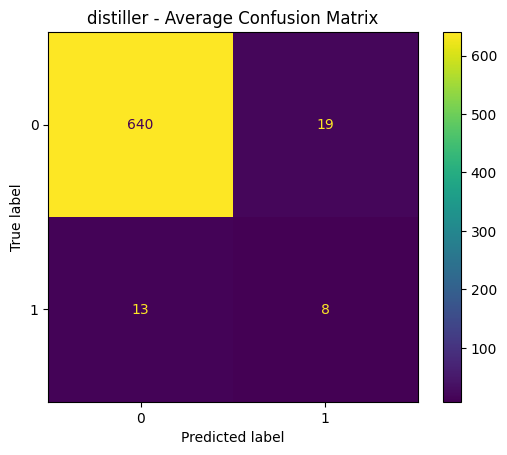

[np.float32(0.1576756), np.float32(0.3641416), np.float32(0.45956558), np.float32(0.32185218), np.float32(0.21755098), np.float32(0.48124328), np.float32(0.36880833), np.float32(0.3007359), np.float32(0.34169707), np.float32(0.3236751), np.float32(0.31515184), np.float32(0.43721324), np.float32(0.33612025), np.float32(0.3474688), np.float32(0.3796879), np.float32(0.50386274), np.float32(0.3648569), np.float32(0.3739003), np.float32(0.4463352), np.float32(0.40513718)]
Average Val PR AUC: 0.3623

 Best Setting: alpha=0.7, temperature=7, AUC PR=0.3623


In [ ]:
# train the model again with the best parameters to get shap and confusion matrix
def teacher():
    # define the model
    model = models.Sequential(name='teacher')
    model.add(Input(shape=(X_pre.shape[1],)))
    # First input layer + repeated blocks
    for i in range(3):
        model.add(layers.Dense(128, activation='relu', kernel_initializer=initializers.GlorotUniform(seed=SEED)))          # Fully connected layer why chose relu https://machinelearningmastery.com/choose-an-activation-function-for-deep-learning/
        model.add(layers.BatchNormalization())                   # Batch normalization
        model.add(layers.Dropout(0.2, seed=SEED))

    # Output layer, choose sigmoid is bc it's a binary classification problem
    model.add(layers.Dense(1))


    return model


def student():
    inputs = keras.Input(shape=(X_pre.shape[1],))
    x = inputs
    for _ in range(3):
        x = layers.Dense(128, activation='relu', kernel_initializer=initializers.GlorotUniform(seed=SEED))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.2, seed=SEED)(x)

    # Two heads: one for hard, one for soft
    hard_output = layers.Dense(1, name='hard_head')(x)
    soft_output = layers.Dense(1, name='soft_head')(x)

    model = keras.Model(inputs=inputs, outputs=[hard_output, soft_output], name="student")
    return model

teacher = teacher()
student = student()
best_alpha_temp = grid_search(
    X=X_pre,
    y=y_pre,
    teacher=teacher,
    student=student,
    alphas=[0.7],
    temps=[7],
    is_best_model=True
)


### replication of the paper from fujiwara (KD+random under sampling)

In [ ]:
class rus_Skfold_Trainer:
  def __init__(self, teacher, X, y, mode, student=None, k=10, num_epochs=200, batch_size=16, verbosity=0, is_best_model=False, rus_test=False):
    # Directly pass the model instance instead of a model function
    self.teacher_template = keras.models.clone_model(teacher)
    self.teacher = None
    self.student_template = keras.models.clone_model(student) if student else None
    self.student = None
    self.X = X
    self.y = y
    self.k = k
    self.num_epochs = num_epochs
    self.batch_size = batch_size
    self.verbosity = verbosity
    self.early_stop = EarlyStopping(monitor='val_loss', patience=5, mode='min', min_delta=0.001, restore_best_weights=True)
    self.mode = mode
    self.is_best_model = is_best_model
    self.rus_test = rus_test

    self.val_loss = {"distiller": [],}
    self.val_roc_aucs = { "distiller": [],}
    self.val_pr_aucs = {"distiller": [],}

    self.loss = {"baseline":[], "teacher": [], "distiller": [],}
    self.roc_aucs = {"baseline":[], "teacher": [], "distiller": [],}
    self.pr_aucs = {"baseline":[], "teacher": [], "distiller": [],}

    self.shap_feature_importances = {"baseline":[], "teacher": [], "distiller": [],}

    self.confusion_metrics = {"baseline":[], "teacher": [], "distiller": [],}


  def train(self, alpha=None, temp=None):
    # skfold = RepeatedStratifiedKFold(n_splits=self.k, n_repeats=2, shuffle=True, random_state=SEED)
    skfold = RepeatedStratifiedKFold(n_splits=self.k, n_repeats=2, random_state=SEED)
    fold_indices = list(skfold.split(self.X, self.y))

    for i in range(self.k*2):
        print(f'\n🔁 Fold {i+1}/{self.k*2} started...')
        train_val_idx, test_idx = fold_indices[i]

        # split train_val into training and validation
        train_idx, val_idx = train_test_split(
            train_val_idx,
            test_size=0.12,
            stratify=self.y.iloc[train_val_idx],
            random_state=SEED
        )

        X_train, y_train = self.X.iloc[train_idx], self.y.iloc[train_idx]
        X_val, y_val = self.X.iloc[val_idx], self.y.iloc[val_idx]
        X_test, y_test = self.X.iloc[test_idx], self.y.iloc[test_idx]

        # train the baseline / teacher model
        if self.mode in ['baseline', "teacher"]:
            if self.mode == 'teacher':
              print("🔄 Applying RUS...")
              rus = RandomUnderSampler(random_state=SEED)
              X_train, y_train = rus.fit_resample(X_train, y_train)


            self.teacher = keras.models.clone_model(self.teacher_template)

            self.teacher.compile(optimizer='adam',
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[SigmoidAUC(name='auc_roc', curve='ROC'),
                        SigmoidAUC(name='auc_pr', curve='PR')])

            history = self.teacher.fit(
                X_train, y_train,
                validation_data=(X_val, y_val),
                epochs=self.num_epochs,
                batch_size=self.batch_size,
                verbose=self.verbosity,
                callbacks=[self.early_stop]
            )

            print(f"Evaluate {self.mode} on training set...")
            train_loss, train_auc_roc, train_auc_pr = self.teacher.evaluate(X_train, y_train, verbose=self.verbosity)
            print(f'✅ Fold {i+1}: {self.mode} Train Loss={train_loss:.4f}, Train ROC AUC={train_auc_roc:.4f}, Train PR AUC={train_auc_pr:.4f}')

            print(f"Evaluate {self.mode} on test set...")
            self.evaluate_model(self.teacher, self.mode, X_test, y_test, i)


            #calculate shap
            self.evaluate_shap(self.teacher, self.mode, X_train, X_test)

            #calculate the confusion matrics
            y_pred = self.teacher.predict(X_test)
            y_pred_binary = (y_pred > 0.5).astype(int)
            cm = metrics.confusion_matrix(y_test, y_pred_binary)
            self.confusion_metrics[self.mode].append(cm)

        #train the student model
        elif self.mode == "distiller":

            print("🔄 Applying RUS...")
            rus = RandomUnderSampler(random_state=SEED)
            X_train, y_train = rus.fit_resample(X_train, y_train)

            self.teacher = keras.models.clone_model(self.teacher_template)

            self.teacher.compile(optimizer='adam',
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[SigmoidAUC(name='auc_roc', curve='ROC'),
                        SigmoidAUC(name='auc_pr', curve='PR')])

            self.teacher.fit(
                X_train, y_train,
                validation_data=(X_val, y_val),
                epochs=self.num_epochs,
                batch_size=self.batch_size,
                verbose=self.verbosity,
                callbacks=[self.early_stop]
            )

            #overfitting test
            print("Evaluate teacher on training set...")
            train_loss, train_auc_roc, train_auc_pr = self.teacher.evaluate(X_train, y_train, verbose=self.verbosity)
            print(f'✅ Fold {i+1}: Teacher Train Loss={train_loss:.4f}, Train ROC AUC={train_auc_roc:.4f}, Train PR AUC={train_auc_pr:.4f}')

            print("Evaluate teacher on test set...")
            self.evaluate_model(self.teacher,'teacher', X_test, y_test, i)

            self.student = keras.models.clone_model(self.student_template)
            distiller = Distiller(student=self.student, teacher=self.teacher)

            distiller.compile(
                optimizer=keras.optimizers.Adam(),
                metrics=[SigmoidAUC(name='auc_roc', curve='ROC'), SigmoidAUC(name='auc_pr', curve='PR')],
                student_loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
                distillation_loss_fn=keras.losses.KLDivergence(),
                alpha=alpha,
                temperature=temp,
            )

            distiller.fit(
                X_train, [y_train, y_train],
                validation_data=(X_val, [y_val, y_val]),
                epochs=self.num_epochs,
                batch_size=self.batch_size,
                verbose=self.verbosity,
                callbacks=[self.early_stop]
            )


            val_loss, val_metrics = distiller.evaluate(X_val, [y_val, y_val], verbose=self.verbosity)
            self.val_roc_aucs['distiller'].append(val_metrics["auc_roc"].numpy())
            self.val_pr_aucs['distiller'].append(val_metrics["auc_pr"].numpy())

            print("Evaluate distiller on training set...")
            distiller_loss, distiller_metrics = distiller.evaluate(X_train, [y_train, y_train], verbose=self.verbosity)
            distiller_auc_roc, distiller_auc_pr = distiller_metrics["auc_roc"].numpy(), distiller_metrics["auc_pr"].numpy()
            print(f'✅ Fold {i+1}: {self.mode} Training Loss={distiller_loss:.4f}, Training ROC AUC={distiller_auc_roc:.4f}, Training PR AUC={distiller_auc_pr:.4f}')

            print("Evaluate distiller on test set...")
            self.evaluate_model(distiller, 'distiller', X_test, [y_test,y_test], i)
            if self.is_best_model:
              #apply shap
              self.evaluate_shap(distiller, self.mode, X_train, X_test)

              #apply confusion matrix
              y_pred = distiller.predict(X_test)
              y_pred_binary = (y_pred > 0.5).astype(int)
              cm = metrics.confusion_matrix(y_test, y_pred_binary)
              self.confusion_metrics[self.mode].append(cm)

    print('average roc auc on the testing set')
    print({key: sum(values)/len(values) if values else None for key, values in self.roc_aucs.items()})
    print('average pr auc on the testing set')
    print({key: sum(values)/len(values) if values else None for key, values in self.pr_aucs.items()})

    print('the standard deviation on test set')
    print(f'SD of {self.mode}\'s roc-auc: {np.std(self.roc_aucs[self.mode])}, SD of {self.mode}\'s pr-auc: {np.std(self.pr_aucs[self.mode])}')

    print('Average Confusion Matrices in testing set:')
    for mode in ["baseline", "teacher", "distiller"]:
      cms = self.confusion_metrics[mode]
      if cms:
          avg_cm = sum(cms) / len(cms)
          print(f"\n🧪 {mode} - Average Confusion Matrix:\n{avg_cm}")
          cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=avg_cm.astype(int), display_labels=[0, 1])
          cm_display.plot()
          plt.title(f"{mode} - Average Confusion Matrix")
          plt.show()


  def evaluate_model(self, model, mode_name, X_test, y_test, fold):
    if mode_name in ['teacher', 'baseline']:
      test_loss, test_auc_roc, test_auc_pr = model.evaluate(X_test, y_test, verbose=self.verbosity)
      print(f'✅ Fold {fold+1}: {mode_name} Test Loss={test_loss:.4f}, Test ROC AUC={test_auc_roc:.4f}, Test PR AUC={test_auc_pr:.4f}')
      self.loss[mode_name].append(test_loss)
      self.roc_aucs[mode_name].append(test_auc_roc)
      self.pr_aucs[mode_name].append(test_auc_pr)
    elif mode_name == 'distiller':
      test_loss, test_metrics = model.evaluate(X_test, y_test, verbose=self.verbosity)
      self.loss[mode_name].append(test_loss.numpy())
      self.roc_aucs[mode_name].append(float(test_metrics["auc_roc"].numpy()))
      self.pr_aucs[mode_name].append(float(test_metrics["auc_pr"].numpy()))
      print(f'✅ Fold {fold+1}: {mode_name} Test Loss={test_loss.numpy():.4f}, Test ROC AUC={test_metrics["auc_roc"].numpy():.4f}, Test PR AUC={test_metrics["auc_pr"].numpy():.4f}')



  def evaluate_shap(self, model, mode_name,X_train, X_explain_df):
    X_train = X_train.to_numpy()
    X_explain = X_explain_df.to_numpy()
    background = shap.utils.sample(X_train, random_state=SEED)
    explain_data = X_explain[:100]

    predict_fn = lambda x: tf.nn.sigmoid(model(x)).numpy()
    explainer = shap.KernelExplainer(predict_fn, background)
    shap_values = explainer.shap_values(explain_data)

    if isinstance(shap_values, list):
        shap_values = shap_values[0]

    # ✅ Save mean SHAP importance per feature for this fold
    mean_shap = np.mean(np.abs(shap_values), axis=0)
    self.shap_feature_importances[mode_name].append(mean_shap)

    print("✅ SHAP vector saved for fold. Shape:", mean_shap.shape)

  def compute_shap_stability(self, mode_name):
    from sklearn.metrics.pairwise import cosine_similarity
    from itertools import combinations

    shap_vectors = self.shap_feature_importances[mode_name]

    similarities = []
    for v1, v2 in combinations(shap_vectors, 2):
        sim = cosine_similarity(v1.reshape(1, -1), v2.reshape(1, -1))[0][0]
        similarities.append(sim)

    sim_M = np.mean(similarities)
    return f"📊 SHAP Stability (sim_M) for {mode_name}: {sim_M:.4f}"
    # return sim_M


🔁 Fold 1/20 started...
🔄 Applying RUS...
Evaluate teacher on training set...
✅ Fold 1: teacher Train Loss=0.7832, Train ROC AUC=0.9345, Train PR AUC=0.9198
Evaluate teacher on test set...
✅ Fold 1: teacher Test Loss=0.1428, Test ROC AUC=0.8778, Test PR AUC=0.2371


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 2/20 started...
🔄 Applying RUS...
Evaluate teacher on training set...
✅ Fold 2: teacher Train Loss=0.7150, Train ROC AUC=0.9340, Train PR AUC=0.9368
Evaluate teacher on test set...
✅ Fold 2: teacher Test Loss=0.1380, Test ROC AUC=0.9417, Test PR AUC=0.3746


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 3/20 started...
🔄 Applying RUS...
Evaluate teacher on training set...
✅ Fold 3: teacher Train Loss=0.7079, Train ROC AUC=0.9365, Train PR AUC=0.9225
Evaluate teacher on test set...
✅ Fold 3: teacher Test Loss=0.2253, Test ROC AUC=0.8794, Test PR AUC=0.2728


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

🔁 Fold 4/20 started...
🔄 Applying RUS...
Evaluate teacher on training set...
✅ Fold 4: teacher Train Loss=0.8737, Train ROC AUC=0.9363, Train PR AUC=0.9341
Evaluate teacher on test set...
✅ Fold 4: teacher Test Loss=0.1168, Test ROC AUC=0.9152, Test PR AUC=0.3696


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 5/20 started...
🔄 Applying RUS...
Evaluate teacher on training set...
✅ Fold 5: teacher Train Loss=0.5710, Train ROC AUC=0.9439, Train PR AUC=0.9438
Evaluate teacher on test set...
✅ Fold 5: teacher Test Loss=0.2180, Test ROC AUC=0.9544, Test PR AUC=0.3750


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 6/20 started...
🔄 Applying RUS...
Evaluate teacher on training set...
✅ Fold 6: teacher Train Loss=1.0110, Train ROC AUC=0.9600, Train PR AUC=0.9612
Evaluate teacher on test set...
✅ Fold 6: teacher Test Loss=0.1037, Test ROC AUC=0.8918, Test PR AUC=0.3287


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 7/20 started...
🔄 Applying RUS...
Evaluate teacher on training set...
✅ Fold 7: teacher Train Loss=0.5854, Train ROC AUC=0.9276, Train PR AUC=0.9129
Evaluate teacher on test set...
✅ Fold 7: teacher Test Loss=0.2022, Test ROC AUC=0.9289, Test PR AUC=0.4102


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

🔁 Fold 8/20 started...
🔄 Applying RUS...
Evaluate teacher on training set...
✅ Fold 8: teacher Train Loss=1.1132, Train ROC AUC=0.9297, Train PR AUC=0.9131
Evaluate teacher on test set...
✅ Fold 8: teacher Test Loss=0.1083, Test ROC AUC=0.8499, Test PR AUC=0.3327


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 9/20 started...
🔄 Applying RUS...
Evaluate teacher on training set...
✅ Fold 9: teacher Train Loss=0.6051, Train ROC AUC=0.9137, Train PR AUC=0.8905
Evaluate teacher on test set...
✅ Fold 9: teacher Test Loss=0.2818, Test ROC AUC=0.8589, Test PR AUC=0.3172


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 10/20 started...
🔄 Applying RUS...
Evaluate teacher on training set...
✅ Fold 10: teacher Train Loss=0.5908, Train ROC AUC=0.9302, Train PR AUC=0.9313
Evaluate teacher on test set...
✅ Fold 10: teacher Test Loss=0.1735, Test ROC AUC=0.9440, Test PR AUC=0.4317


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 11/20 started...
🔄 Applying RUS...
Evaluate teacher on training set...
✅ Fold 11: teacher Train Loss=0.4953, Train ROC AUC=0.9640, Train PR AUC=0.9643
Evaluate teacher on test set...
✅ Fold 11: teacher Test Loss=0.1333, Test ROC AUC=0.9024, Test PR AUC=0.3279


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 12/20 started...
🔄 Applying RUS...
Evaluate teacher on training set...
✅ Fold 12: teacher Train Loss=0.6614, Train ROC AUC=0.9360, Train PR AUC=0.9290
Evaluate teacher on test set...
✅ Fold 12: teacher Test Loss=0.1646, Test ROC AUC=0.9277, Test PR AUC=0.3564


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

🔁 Fold 13/20 started...
🔄 Applying RUS...
Evaluate teacher on training set...
✅ Fold 13: teacher Train Loss=0.7125, Train ROC AUC=0.9393, Train PR AUC=0.9332
Evaluate teacher on test set...
✅ Fold 13: teacher Test Loss=0.1259, Test ROC AUC=0.9293, Test PR AUC=0.3487


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

🔁 Fold 14/20 started...
🔄 Applying RUS...
Evaluate teacher on training set...
✅ Fold 14: teacher Train Loss=0.7330, Train ROC AUC=0.9432, Train PR AUC=0.9485
Evaluate teacher on test set...
✅ Fold 14: teacher Test Loss=0.1379, Test ROC AUC=0.9139, Test PR AUC=0.3022


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 15/20 started...
🔄 Applying RUS...
Evaluate teacher on training set...
✅ Fold 15: teacher Train Loss=0.9592, Train ROC AUC=0.9465, Train PR AUC=0.9382
Evaluate teacher on test set...
✅ Fold 15: teacher Test Loss=0.1100, Test ROC AUC=0.9094, Test PR AUC=0.3091


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

🔁 Fold 16/20 started...
🔄 Applying RUS...
Evaluate teacher on training set...
✅ Fold 16: teacher Train Loss=0.8342, Train ROC AUC=0.9007, Train PR AUC=0.8817
Evaluate teacher on test set...
✅ Fold 16: teacher Test Loss=0.1850, Test ROC AUC=0.9049, Test PR AUC=0.3889


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

🔁 Fold 17/20 started...
🔄 Applying RUS...
Evaluate teacher on training set...
✅ Fold 17: teacher Train Loss=0.8386, Train ROC AUC=0.9330, Train PR AUC=0.9327
Evaluate teacher on test set...
✅ Fold 17: teacher Test Loss=0.1324, Test ROC AUC=0.9169, Test PR AUC=0.3780


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

🔁 Fold 18/20 started...
🔄 Applying RUS...
Evaluate teacher on training set...
✅ Fold 18: teacher Train Loss=0.8837, Train ROC AUC=0.9316, Train PR AUC=0.9174
Evaluate teacher on test set...
✅ Fold 18: teacher Test Loss=0.1198, Test ROC AUC=0.8461, Test PR AUC=0.1794


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 19/20 started...
🔄 Applying RUS...
Evaluate teacher on training set...
✅ Fold 19: teacher Train Loss=0.7739, Train ROC AUC=0.9203, Train PR AUC=0.9183
Evaluate teacher on test set...
✅ Fold 19: teacher Test Loss=0.2049, Test ROC AUC=0.9282, Test PR AUC=0.3063


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

🔁 Fold 20/20 started...
🔄 Applying RUS...
Evaluate teacher on training set...
✅ Fold 20: teacher Train Loss=0.5142, Train ROC AUC=0.9458, Train PR AUC=0.9356
Evaluate teacher on test set...
✅ Fold 20: teacher Test Loss=0.1655, Test ROC AUC=0.8961, Test PR AUC=0.3320


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
average roc auc on the testing set
{'baseline': None, 'teacher': 0.9058418720960617, 'distiller': None}
average pr auc on the testing set
{'baseline': None, 'teacher': 0.3339220382273197, 'distiller': None}
the standard deviation on test set
SD of teacher's roc-auc: 0.030109604631361, SD of teacher's pr-auc: 0.05720130782027363
Average Confusion Matrices in testing set:

🧪 teacher - Average Confusion Matrix:
[[658.15   1.75]
 [ 20.15   1.85]]


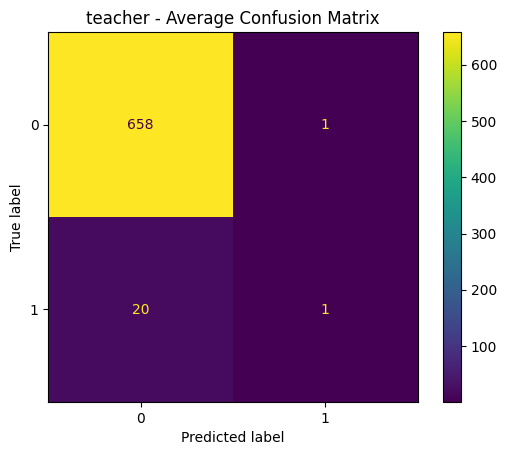

'📊 SHAP Stability (sim_M) for teacher: 0.7637'

In [ ]:
# train the teacher model
teacher = teacher()

teacher_skfold_trainer = rus_Skfold_Trainer(mode='teacher', teacher=teacher, X=X_pre, y=y_pre)
teacher_skfold_trainer.train()
teacher_skfold_trainer.compute_shap_stability("teacher")


🔁 Fold 1/20 started...
🔄 Applying RUS...
Evaluate teacher on training set...
✅ Fold 1: Teacher Train Loss=0.6968, Train ROC AUC=0.9235, Train PR AUC=0.9020
Evaluate teacher on test set...
✅ Fold 1: teacher Test Loss=0.1650, Test ROC AUC=0.8677, Test PR AUC=0.2600
Evaluate distiller on training set...
✅ Fold 1: distiller Training Loss=0.9972, Training ROC AUC=0.7829, Training PR AUC=0.7811
Evaluate distiller on test set...
✅ Fold 1: distiller Test Loss=0.4257, Test ROC AUC=0.7134, Test PR AUC=0.1614


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

🔁 Fold 2/20 started...
🔄 Applying RUS...
Evaluate teacher on training set...
✅ Fold 2: Teacher Train Loss=0.6762, Train ROC AUC=0.9382, Train PR AUC=0.9278
Evaluate teacher on test set...
✅ Fold 2: teacher Test Loss=0.2431, Test ROC AUC=0.9448, Test PR AUC=0.3353
Evaluate distiller on training set...
✅ Fold 2: distiller Training Loss=0.6320, Training ROC AUC=0.9589, Training PR AUC=0.9568
Evaluate distiller on test set...
✅ Fold 2: distiller Test Loss=0.1869, Test ROC AUC=0.9324, Test PR AUC=0.3033


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

🔁 Fold 3/20 started...
🔄 Applying RUS...
Evaluate teacher on training set...
✅ Fold 3: Teacher Train Loss=0.5998, Train ROC AUC=0.9433, Train PR AUC=0.9355
Evaluate teacher on test set...
✅ Fold 3: teacher Test Loss=0.1449, Test ROC AUC=0.8795, Test PR AUC=0.1990
Evaluate distiller on training set...
✅ Fold 3: distiller Training Loss=0.4518, Training ROC AUC=0.9518, Training PR AUC=0.9489
Evaluate distiller on test set...
✅ Fold 3: distiller Test Loss=0.3051, Test ROC AUC=0.8813, Test PR AUC=0.2187


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

🔁 Fold 4/20 started...
🔄 Applying RUS...
Evaluate teacher on training set...
✅ Fold 4: Teacher Train Loss=0.6961, Train ROC AUC=0.9427, Train PR AUC=0.9394
Evaluate teacher on test set...
✅ Fold 4: teacher Test Loss=0.1278, Test ROC AUC=0.9399, Test PR AUC=0.3560
Evaluate distiller on training set...
✅ Fold 4: distiller Training Loss=0.6733, Training ROC AUC=0.9185, Training PR AUC=0.9202
Evaluate distiller on test set...
✅ Fold 4: distiller Test Loss=0.0264, Test ROC AUC=0.9174, Test PR AUC=0.3002


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

🔁 Fold 5/20 started...
🔄 Applying RUS...
Evaluate teacher on training set...
✅ Fold 5: Teacher Train Loss=0.7438, Train ROC AUC=0.9075, Train PR AUC=0.9083
Evaluate teacher on test set...
✅ Fold 5: teacher Test Loss=0.2966, Test ROC AUC=0.8989, Test PR AUC=0.2030
Evaluate distiller on training set...
✅ Fold 5: distiller Training Loss=0.5186, Training ROC AUC=0.9457, Training PR AUC=0.9453
Evaluate distiller on test set...
✅ Fold 5: distiller Test Loss=0.0755, Test ROC AUC=0.9601, Test PR AUC=0.3713


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 6/20 started...
🔄 Applying RUS...
Evaluate teacher on training set...
✅ Fold 6: Teacher Train Loss=0.6787, Train ROC AUC=0.9563, Train PR AUC=0.9582
Evaluate teacher on test set...
✅ Fold 6: teacher Test Loss=0.1315, Test ROC AUC=0.8923, Test PR AUC=0.3847
Evaluate distiller on training set...
✅ Fold 6: distiller Training Loss=0.9431, Training ROC AUC=0.9460, Training PR AUC=0.9511
Evaluate distiller on test set...
✅ Fold 6: distiller Test Loss=0.0639, Test ROC AUC=0.9337, Test PR AUC=0.3806


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 7/20 started...
🔄 Applying RUS...
Evaluate teacher on training set...
✅ Fold 7: Teacher Train Loss=0.8059, Train ROC AUC=0.9116, Train PR AUC=0.8923
Evaluate teacher on test set...
✅ Fold 7: teacher Test Loss=0.1999, Test ROC AUC=0.9230, Test PR AUC=0.3924
Evaluate distiller on training set...
✅ Fold 7: distiller Training Loss=0.9796, Training ROC AUC=0.9075, Training PR AUC=0.8820
Evaluate distiller on test set...
✅ Fold 7: distiller Test Loss=0.3708, Test ROC AUC=0.8901, Test PR AUC=0.2830


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 8/20 started...
🔄 Applying RUS...
Evaluate teacher on training set...
✅ Fold 8: Teacher Train Loss=0.9537, Train ROC AUC=0.9390, Train PR AUC=0.9342
Evaluate teacher on test set...
✅ Fold 8: teacher Test Loss=0.1154, Test ROC AUC=0.8549, Test PR AUC=0.2891
Evaluate distiller on training set...
✅ Fold 8: distiller Training Loss=1.0923, Training ROC AUC=0.9629, Training PR AUC=0.9638
Evaluate distiller on test set...
✅ Fold 8: distiller Test Loss=0.4031, Test ROC AUC=0.8059, Test PR AUC=0.2764


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 9/20 started...
🔄 Applying RUS...
Evaluate teacher on training set...
✅ Fold 9: Teacher Train Loss=0.4914, Train ROC AUC=0.9457, Train PR AUC=0.9384
Evaluate teacher on test set...
✅ Fold 9: teacher Test Loss=0.3454, Test ROC AUC=0.9273, Test PR AUC=0.3266
Evaluate distiller on training set...
✅ Fold 9: distiller Training Loss=0.9888, Training ROC AUC=0.9320, Training PR AUC=0.9045
Evaluate distiller on test set...
✅ Fold 9: distiller Test Loss=0.1711, Test ROC AUC=0.8902, Test PR AUC=0.3222


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

🔁 Fold 10/20 started...
🔄 Applying RUS...
Evaluate teacher on training set...
✅ Fold 10: Teacher Train Loss=0.6862, Train ROC AUC=0.8682, Train PR AUC=0.8663
Evaluate teacher on test set...
✅ Fold 10: teacher Test Loss=0.5086, Test ROC AUC=0.8949, Test PR AUC=0.2657
Evaluate distiller on training set...
✅ Fold 10: distiller Training Loss=0.6603, Training ROC AUC=0.9369, Training PR AUC=0.9379
Evaluate distiller on test set...
✅ Fold 10: distiller Test Loss=0.1367, Test ROC AUC=0.9640, Test PR AUC=0.4902


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

🔁 Fold 11/20 started...
🔄 Applying RUS...
Evaluate teacher on training set...
✅ Fold 11: Teacher Train Loss=0.5842, Train ROC AUC=0.9505, Train PR AUC=0.9512
Evaluate teacher on test set...
✅ Fold 11: teacher Test Loss=0.1846, Test ROC AUC=0.9068, Test PR AUC=0.3173
Evaluate distiller on training set...
✅ Fold 11: distiller Training Loss=1.3341, Training ROC AUC=0.9497, Training PR AUC=0.9474
Evaluate distiller on test set...
✅ Fold 11: distiller Test Loss=0.1321, Test ROC AUC=0.9291, Test PR AUC=0.3651


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 12/20 started...
🔄 Applying RUS...
Evaluate teacher on training set...
✅ Fold 12: Teacher Train Loss=0.6883, Train ROC AUC=0.9391, Train PR AUC=0.9254
Evaluate teacher on test set...
✅ Fold 12: teacher Test Loss=0.2988, Test ROC AUC=0.9456, Test PR AUC=0.3776
Evaluate distiller on training set...
✅ Fold 12: distiller Training Loss=0.2942, Training ROC AUC=0.9594, Training PR AUC=0.9582
Evaluate distiller on test set...
✅ Fold 12: distiller Test Loss=0.3170, Test ROC AUC=0.9409, Test PR AUC=0.3842


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

🔁 Fold 13/20 started...
🔄 Applying RUS...
Evaluate teacher on training set...
✅ Fold 13: Teacher Train Loss=0.9580, Train ROC AUC=0.9436, Train PR AUC=0.9377
Evaluate teacher on test set...
✅ Fold 13: teacher Test Loss=0.0986, Test ROC AUC=0.9184, Test PR AUC=0.3752
Evaluate distiller on training set...
✅ Fold 13: distiller Training Loss=0.4593, Training ROC AUC=0.9604, Training PR AUC=0.9546
Evaluate distiller on test set...
✅ Fold 13: distiller Test Loss=0.0145, Test ROC AUC=0.9275, Test PR AUC=0.4120


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

🔁 Fold 14/20 started...
🔄 Applying RUS...
Evaluate teacher on training set...
✅ Fold 14: Teacher Train Loss=1.1275, Train ROC AUC=0.9501, Train PR AUC=0.9547
Evaluate teacher on test set...
✅ Fold 14: teacher Test Loss=0.1136, Test ROC AUC=0.9216, Test PR AUC=0.3062
Evaluate distiller on training set...
✅ Fold 14: distiller Training Loss=1.4867, Training ROC AUC=0.9367, Training PR AUC=0.9413
Evaluate distiller on test set...
✅ Fold 14: distiller Test Loss=0.0300, Test ROC AUC=0.8644, Test PR AUC=0.2534


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 15/20 started...
🔄 Applying RUS...
Evaluate teacher on training set...
✅ Fold 15: Teacher Train Loss=0.7906, Train ROC AUC=0.9486, Train PR AUC=0.9426
Evaluate teacher on test set...
✅ Fold 15: teacher Test Loss=0.1128, Test ROC AUC=0.9201, Test PR AUC=0.2669
Evaluate distiller on training set...
✅ Fold 15: distiller Training Loss=0.9744, Training ROC AUC=0.9420, Training PR AUC=0.9414
Evaluate distiller on test set...
✅ Fold 15: distiller Test Loss=0.0807, Test ROC AUC=0.9150, Test PR AUC=0.3234


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 16/20 started...
🔄 Applying RUS...
Evaluate teacher on training set...
✅ Fold 16: Teacher Train Loss=0.6693, Train ROC AUC=0.9187, Train PR AUC=0.9062
Evaluate teacher on test set...
✅ Fold 16: teacher Test Loss=0.2529, Test ROC AUC=0.9247, Test PR AUC=0.3970
Evaluate distiller on training set...
✅ Fold 16: distiller Training Loss=0.0403, Training ROC AUC=0.9494, Training PR AUC=0.9430
Evaluate distiller on test set...
✅ Fold 16: distiller Test Loss=0.2984, Test ROC AUC=0.9128, Test PR AUC=0.3363


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

🔁 Fold 17/20 started...
🔄 Applying RUS...
Evaluate teacher on training set...
✅ Fold 17: Teacher Train Loss=0.8947, Train ROC AUC=0.9021, Train PR AUC=0.9008
Evaluate teacher on test set...
✅ Fold 17: teacher Test Loss=0.1181, Test ROC AUC=0.9021, Test PR AUC=0.3007
Evaluate distiller on training set...
✅ Fold 17: distiller Training Loss=1.1344, Training ROC AUC=0.9322, Training PR AUC=0.9320
Evaluate distiller on test set...
✅ Fold 17: distiller Test Loss=0.1551, Test ROC AUC=0.9095, Test PR AUC=0.3512


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

🔁 Fold 18/20 started...
🔄 Applying RUS...
Evaluate teacher on training set...
✅ Fold 18: Teacher Train Loss=0.8401, Train ROC AUC=0.9225, Train PR AUC=0.9058
Evaluate teacher on test set...
✅ Fold 18: teacher Test Loss=0.1629, Test ROC AUC=0.8687, Test PR AUC=0.1467
Evaluate distiller on training set...
✅ Fold 18: distiller Training Loss=1.1880, Training ROC AUC=0.9030, Training PR AUC=0.8987
Evaluate distiller on test set...
✅ Fold 18: distiller Test Loss=0.2684, Test ROC AUC=0.8850, Test PR AUC=0.2014


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 19/20 started...
🔄 Applying RUS...
Evaluate teacher on training set...
✅ Fold 19: Teacher Train Loss=0.5967, Train ROC AUC=0.9194, Train PR AUC=0.9222
Evaluate teacher on test set...
✅ Fold 19: teacher Test Loss=0.2113, Test ROC AUC=0.9113, Test PR AUC=0.2903
Evaluate distiller on training set...
✅ Fold 19: distiller Training Loss=0.6995, Training ROC AUC=0.9509, Training PR AUC=0.9515
Evaluate distiller on test set...
✅ Fold 19: distiller Test Loss=0.1667, Test ROC AUC=0.9415, Test PR AUC=0.3711


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 20/20 started...
🔄 Applying RUS...
Evaluate teacher on training set...
✅ Fold 20: Teacher Train Loss=0.6060, Train ROC AUC=0.9103, Train PR AUC=0.8892
Evaluate teacher on test set...
✅ Fold 20: teacher Test Loss=0.2869, Test ROC AUC=0.8318, Test PR AUC=0.1857
Evaluate distiller on training set...
✅ Fold 20: distiller Training Loss=0.2959, Training ROC AUC=0.9445, Training PR AUC=0.9407
Evaluate distiller on test set...
✅ Fold 20: distiller Test Loss=0.4102, Test ROC AUC=0.8635, Test PR AUC=0.2889


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
average roc auc on the testing set
{'baseline': None, 'teacher': 0.9037052005529403, 'distiller': 0.8988832861185074}
average pr auc on the testing set
{'baseline': None, 'teacher': 0.29877374321222305, 'distiller': 0.3197233445942402}
the standard deviation on test set
SD of distiller's roc-auc: 0.05597697658258007, SD of distiller's pr-auc: 0.07503179767058771
Average Confusion Matrices in testing set:

🧪 distiller - Average Confusion Matrix:
[[634.95  24.95]
 [ 14.     8.  ]]


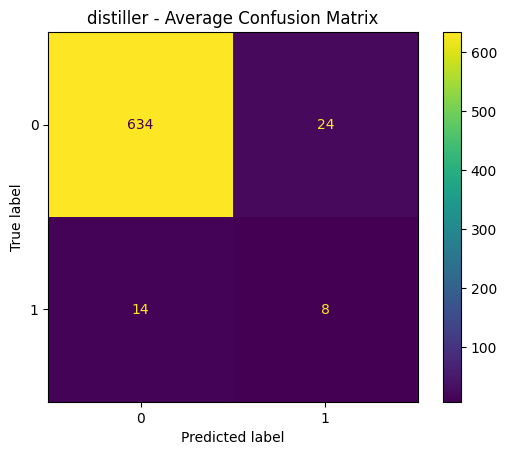

'📊 SHAP Stability (sim_M) for distiller: 0.7562'

In [ ]:
# train the student model on the bast parameter(from the paper)
teacher = teacher()
student = student()
teacher_skfold_trainer = rus_Skfold_Trainer(mode='distiller', teacher=teacher, student=student, X=X_pre, y=y_pre, is_best_model=True)
teacher_skfold_trainer.train(alpha=0.3, temp=5)
teacher_skfold_trainer.compute_shap_stability("distiller")

### try rus with optimizers=sgd


🔁 Fold 1/20 started...
🔄 Applying SMOTE...
🔄 Applying RUS...
Evaluate teacher on training set...
✅ Fold 1: Teacher Train Loss=0.5715, Train ROC AUC=0.9170, Train PR AUC=0.8938
Evaluate teacher on test set...
✅ Fold 1: teacher Test Loss=0.2399, Test ROC AUC=0.8743, Test PR AUC=0.2565
Evaluate distiller on training set...
✅ Fold 1: distiller Training Loss=1.0693, Training ROC AUC=0.8460, Training PR AUC=0.8212
Evaluate distiller on test set...
✅ Fold 1: distiller Test Loss=0.3484, Test ROC AUC=0.7597, Test PR AUC=0.1792


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 2/20 started...
🔄 Applying SMOTE...
🔄 Applying RUS...
Evaluate teacher on training set...
✅ Fold 2: Teacher Train Loss=0.6031, Train ROC AUC=0.9382, Train PR AUC=0.9419
Evaluate teacher on test set...
✅ Fold 2: teacher Test Loss=0.1500, Test ROC AUC=0.9525, Test PR AUC=0.3535
Evaluate distiller on training set...
✅ Fold 2: distiller Training Loss=0.1401, Training ROC AUC=0.9648, Training PR AUC=0.9657
Evaluate distiller on test set...
✅ Fold 2: distiller Test Loss=0.5459, Test ROC AUC=0.9428, Test PR AUC=0.3116


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 3/20 started...
🔄 Applying SMOTE...
🔄 Applying RUS...
Evaluate teacher on training set...
✅ Fold 3: Teacher Train Loss=0.6249, Train ROC AUC=0.9435, Train PR AUC=0.9406
Evaluate teacher on test set...
✅ Fold 3: teacher Test Loss=0.1331, Test ROC AUC=0.8880, Test PR AUC=0.2848
Evaluate distiller on training set...
✅ Fold 3: distiller Training Loss=0.3314, Training ROC AUC=0.9575, Training PR AUC=0.9591
Evaluate distiller on test set...
✅ Fold 3: distiller Test Loss=0.5582, Test ROC AUC=0.8842, Test PR AUC=0.2511


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 4/20 started...
🔄 Applying SMOTE...
🔄 Applying RUS...
Evaluate teacher on training set...
✅ Fold 4: Teacher Train Loss=0.9957, Train ROC AUC=0.9330, Train PR AUC=0.9334
Evaluate teacher on test set...
✅ Fold 4: teacher Test Loss=0.0920, Test ROC AUC=0.9418, Test PR AUC=0.4280
Evaluate distiller on training set...
✅ Fold 4: distiller Training Loss=0.4976, Training ROC AUC=0.9531, Training PR AUC=0.9499
Evaluate distiller on test set...
✅ Fold 4: distiller Test Loss=0.0531, Test ROC AUC=0.9444, Test PR AUC=0.3706


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 5/20 started...
🔄 Applying SMOTE...
🔄 Applying RUS...
Evaluate teacher on training set...
✅ Fold 5: Teacher Train Loss=0.9546, Train ROC AUC=0.9178, Train PR AUC=0.9133
Evaluate teacher on test set...
✅ Fold 5: teacher Test Loss=0.1374, Test ROC AUC=0.9171, Test PR AUC=0.2570
Evaluate distiller on training set...
✅ Fold 5: distiller Training Loss=0.3362, Training ROC AUC=0.9563, Training PR AUC=0.9583
Evaluate distiller on test set...
✅ Fold 5: distiller Test Loss=0.1190, Test ROC AUC=0.9612, Test PR AUC=0.4052


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 6/20 started...
🔄 Applying SMOTE...
🔄 Applying RUS...
Evaluate teacher on training set...
✅ Fold 6: Teacher Train Loss=1.0344, Train ROC AUC=0.9398, Train PR AUC=0.9422
Evaluate teacher on test set...
✅ Fold 6: teacher Test Loss=0.1634, Test ROC AUC=0.9069, Test PR AUC=0.3124
Evaluate distiller on training set...
✅ Fold 6: distiller Training Loss=1.4203, Training ROC AUC=0.9273, Training PR AUC=0.9293
Evaluate distiller on test set...
✅ Fold 6: distiller Test Loss=0.1546, Test ROC AUC=0.8572, Test PR AUC=0.2974


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 7/20 started...
🔄 Applying SMOTE...
🔄 Applying RUS...
Evaluate teacher on training set...
✅ Fold 7: Teacher Train Loss=0.9315, Train ROC AUC=0.8789, Train PR AUC=0.8432
Evaluate teacher on test set...
✅ Fold 7: teacher Test Loss=0.1318, Test ROC AUC=0.8382, Test PR AUC=0.2938
Evaluate distiller on training set...
✅ Fold 7: distiller Training Loss=1.1999, Training ROC AUC=0.9072, Training PR AUC=0.8869
Evaluate distiller on test set...
✅ Fold 7: distiller Test Loss=0.2068, Test ROC AUC=0.8858, Test PR AUC=0.2757


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 8/20 started...
🔄 Applying SMOTE...
🔄 Applying RUS...
Evaluate teacher on training set...
✅ Fold 8: Teacher Train Loss=0.7881, Train ROC AUC=0.8981, Train PR AUC=0.8741
Evaluate teacher on test set...
✅ Fold 8: teacher Test Loss=0.1543, Test ROC AUC=0.8441, Test PR AUC=0.3738
Evaluate distiller on training set...
✅ Fold 8: distiller Training Loss=1.1640, Training ROC AUC=0.9435, Training PR AUC=0.9352
Evaluate distiller on test set...
✅ Fold 8: distiller Test Loss=0.0960, Test ROC AUC=0.8719, Test PR AUC=0.3465


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 9/20 started...
🔄 Applying SMOTE...
🔄 Applying RUS...
Evaluate teacher on training set...
✅ Fold 9: Teacher Train Loss=0.5086, Train ROC AUC=0.9425, Train PR AUC=0.9372
Evaluate teacher on test set...
✅ Fold 9: teacher Test Loss=0.1882, Test ROC AUC=0.9510, Test PR AUC=0.3685
Evaluate distiller on training set...
✅ Fold 9: distiller Training Loss=0.7365, Training ROC AUC=0.9307, Training PR AUC=0.9267
Evaluate distiller on test set...
✅ Fold 9: distiller Test Loss=0.2857, Test ROC AUC=0.9145, Test PR AUC=0.3236


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

🔁 Fold 10/20 started...
🔄 Applying SMOTE...
🔄 Applying RUS...
Evaluate teacher on training set...
✅ Fold 10: Teacher Train Loss=0.9175, Train ROC AUC=0.9235, Train PR AUC=0.9230
Evaluate teacher on test set...
✅ Fold 10: teacher Test Loss=0.1510, Test ROC AUC=0.9346, Test PR AUC=0.4216
Evaluate distiller on training set...
✅ Fold 10: distiller Training Loss=0.1741, Training ROC AUC=0.9654, Training PR AUC=0.9646
Evaluate distiller on test set...
✅ Fold 10: distiller Test Loss=0.1574, Test ROC AUC=0.9538, Test PR AUC=0.4423


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 11/20 started...
🔄 Applying SMOTE...
🔄 Applying RUS...
Evaluate teacher on training set...
✅ Fold 11: Teacher Train Loss=0.7599, Train ROC AUC=0.9581, Train PR AUC=0.9630
Evaluate teacher on test set...
✅ Fold 11: teacher Test Loss=0.1278, Test ROC AUC=0.9020, Test PR AUC=0.2695
Evaluate distiller on training set...
✅ Fold 11: distiller Training Loss=1.2628, Training ROC AUC=0.9367, Training PR AUC=0.9312
Evaluate distiller on test set...
✅ Fold 11: distiller Test Loss=0.2260, Test ROC AUC=0.9168, Test PR AUC=0.3266


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

🔁 Fold 12/20 started...
🔄 Applying SMOTE...
🔄 Applying RUS...
Evaluate teacher on training set...
✅ Fold 12: Teacher Train Loss=0.7178, Train ROC AUC=0.9432, Train PR AUC=0.9274
Evaluate teacher on test set...
✅ Fold 12: teacher Test Loss=0.1470, Test ROC AUC=0.9394, Test PR AUC=0.3591
Evaluate distiller on training set...
✅ Fold 12: distiller Training Loss=0.3844, Training ROC AUC=0.9672, Training PR AUC=0.9697
Evaluate distiller on test set...
✅ Fold 12: distiller Test Loss=0.1249, Test ROC AUC=0.9427, Test PR AUC=0.3348


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

🔁 Fold 13/20 started...
🔄 Applying SMOTE...
🔄 Applying RUS...
Evaluate teacher on training set...
✅ Fold 13: Teacher Train Loss=1.1596, Train ROC AUC=0.9301, Train PR AUC=0.9166
Evaluate teacher on test set...
✅ Fold 13: teacher Test Loss=0.1032, Test ROC AUC=0.9224, Test PR AUC=0.2937
Evaluate distiller on training set...
✅ Fold 13: distiller Training Loss=0.2552, Training ROC AUC=0.9524, Training PR AUC=0.9486
Evaluate distiller on test set...
✅ Fold 13: distiller Test Loss=0.0383, Test ROC AUC=0.9231, Test PR AUC=0.3331


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

🔁 Fold 14/20 started...
🔄 Applying SMOTE...
🔄 Applying RUS...
Evaluate teacher on training set...
✅ Fold 14: Teacher Train Loss=0.9128, Train ROC AUC=0.9181, Train PR AUC=0.9212
Evaluate teacher on test set...
✅ Fold 14: teacher Test Loss=0.1241, Test ROC AUC=0.8833, Test PR AUC=0.2966
Evaluate distiller on training set...
✅ Fold 14: distiller Training Loss=0.3062, Training ROC AUC=0.9617, Training PR AUC=0.9639
Evaluate distiller on test set...
✅ Fold 14: distiller Test Loss=0.2333, Test ROC AUC=0.9371, Test PR AUC=0.4138


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

🔁 Fold 15/20 started...
🔄 Applying SMOTE...
🔄 Applying RUS...
Evaluate teacher on training set...
✅ Fold 15: Teacher Train Loss=0.9131, Train ROC AUC=0.9299, Train PR AUC=0.9199
Evaluate teacher on test set...
✅ Fold 15: teacher Test Loss=0.1254, Test ROC AUC=0.8944, Test PR AUC=0.1973
Evaluate distiller on training set...
✅ Fold 15: distiller Training Loss=0.7124, Training ROC AUC=0.9440, Training PR AUC=0.9430
Evaluate distiller on test set...
✅ Fold 15: distiller Test Loss=0.1469, Test ROC AUC=0.9106, Test PR AUC=0.3034


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 16/20 started...
🔄 Applying SMOTE...
🔄 Applying RUS...
Evaluate teacher on training set...
✅ Fold 16: Teacher Train Loss=0.9610, Train ROC AUC=0.9216, Train PR AUC=0.9135
Evaluate teacher on test set...
✅ Fold 16: teacher Test Loss=0.1344, Test ROC AUC=0.9134, Test PR AUC=0.4080
Evaluate distiller on training set...
✅ Fold 16: distiller Training Loss=0.1474, Training ROC AUC=0.9543, Training PR AUC=0.9547
Evaluate distiller on test set...
✅ Fold 16: distiller Test Loss=0.1148, Test ROC AUC=0.9110, Test PR AUC=0.3820


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

🔁 Fold 17/20 started...
🔄 Applying SMOTE...
🔄 Applying RUS...
Evaluate teacher on training set...
✅ Fold 17: Teacher Train Loss=1.0286, Train ROC AUC=0.9401, Train PR AUC=0.9373
Evaluate teacher on test set...
✅ Fold 17: teacher Test Loss=0.1574, Test ROC AUC=0.9309, Test PR AUC=0.3891
Evaluate distiller on training set...
✅ Fold 17: distiller Training Loss=1.1497, Training ROC AUC=0.9504, Training PR AUC=0.9486
Evaluate distiller on test set...
✅ Fold 17: distiller Test Loss=0.1346, Test ROC AUC=0.9373, Test PR AUC=0.4606


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 18/20 started...
🔄 Applying SMOTE...
🔄 Applying RUS...
Evaluate teacher on training set...
✅ Fold 18: Teacher Train Loss=1.2291, Train ROC AUC=0.9052, Train PR AUC=0.8817
Evaluate teacher on test set...
✅ Fold 18: teacher Test Loss=0.1277, Test ROC AUC=0.8058, Test PR AUC=0.0852
Evaluate distiller on training set...
✅ Fold 18: distiller Training Loss=1.5000, Training ROC AUC=0.9180, Training PR AUC=0.9101
Evaluate distiller on test set...
✅ Fold 18: distiller Test Loss=0.1224, Test ROC AUC=0.8935, Test PR AUC=0.2443


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 19/20 started...
🔄 Applying SMOTE...
🔄 Applying RUS...
Evaluate teacher on training set...
✅ Fold 19: Teacher Train Loss=0.9911, Train ROC AUC=0.9395, Train PR AUC=0.9382
Evaluate teacher on test set...
✅ Fold 19: teacher Test Loss=0.1010, Test ROC AUC=0.9387, Test PR AUC=0.3806
Evaluate distiller on training set...
✅ Fold 19: distiller Training Loss=0.4980, Training ROC AUC=0.9470, Training PR AUC=0.9440
Evaluate distiller on test set...
✅ Fold 19: distiller Test Loss=0.1707, Test ROC AUC=0.9418, Test PR AUC=0.3776


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 20/20 started...
🔄 Applying SMOTE...
🔄 Applying RUS...
Evaluate teacher on training set...
✅ Fold 20: Teacher Train Loss=0.6589, Train ROC AUC=0.9077, Train PR AUC=0.8845
Evaluate teacher on test set...
✅ Fold 20: teacher Test Loss=0.1664, Test ROC AUC=0.8522, Test PR AUC=0.2992
Evaluate distiller on training set...
✅ Fold 20: distiller Training Loss=0.2173, Training ROC AUC=0.9647, Training PR AUC=0.9637
Evaluate distiller on test set...
✅ Fold 20: distiller Test Loss=0.6812, Test ROC AUC=0.8794, Test PR AUC=0.2644


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
average roc auc on the testing set
{'baseline': None, 'teacher': 0.9015541046857833, 'distiller': 0.9084360539913178}
average pr auc on the testing set
{'baseline': None, 'teacher': 0.316411691531539, 'distiller': 0.3321908250451088}
the standard deviation on test set
SD of distiller's roc-auc: 0.04462645417876575, SD of distiller's pr-auc: 0.06887871799122677
Average Confusion Matrices in testing set:

🧪 distiller - Average Confusion Matrix:
[[625.7   34.2 ]
 [ 11.75  10.25]]


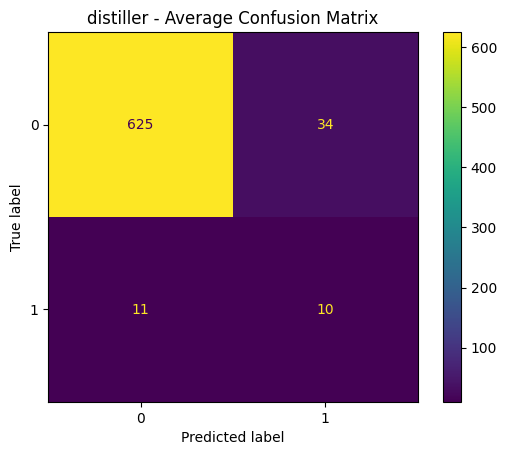

'📊 SHAP Stability (sim_M) for distiller: 0.7791'

In [ ]:
teacher = teacher()
student = student()
teacher_skfold_trainer = Skfold_Trainer(mode='distiller', teacher=teacher, student=student, X=X_pre, y=y_pre,rus_test=True, is_best_model=True)
teacher_skfold_trainer.train(alpha=0.3, temp=5)
teacher_skfold_trainer.compute_shap_stability("distiller")


🔁 Fold 1/20 started...
Evaluate baseline on training set...
✅ Fold 1: baseline Train Loss=0.0893, Train ROC AUC=0.9457, Train PR AUC=0.4521
Evaluate baseline on test set...
✅ Fold 1: baseline Test Loss=0.1304, Test ROC AUC=0.9071, Test PR AUC=0.2624


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

🔁 Fold 2/20 started...
Evaluate baseline on training set...
✅ Fold 2: baseline Train Loss=0.0921, Train ROC AUC=0.9354, Train PR AUC=0.4141
Evaluate baseline on test set...
✅ Fold 2: baseline Test Loss=0.0991, Test ROC AUC=0.9461, Test PR AUC=0.3770


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 3/20 started...
Evaluate baseline on training set...
✅ Fold 3: baseline Train Loss=0.0882, Train ROC AUC=0.9454, Train PR AUC=0.4116
Evaluate baseline on test set...
✅ Fold 3: baseline Test Loss=0.0996, Test ROC AUC=0.8949, Test PR AUC=0.3588


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 4/20 started...
Evaluate baseline on training set...
✅ Fold 4: baseline Train Loss=0.0869, Train ROC AUC=0.9419, Train PR AUC=0.4255
Evaluate baseline on test set...
✅ Fold 4: baseline Test Loss=0.0834, Test ROC AUC=0.9582, Test PR AUC=0.4542


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 5/20 started...
Evaluate baseline on training set...
✅ Fold 5: baseline Train Loss=0.0868, Train ROC AUC=0.9422, Train PR AUC=0.4461
Evaluate baseline on test set...
✅ Fold 5: baseline Test Loss=0.1149, Test ROC AUC=0.9386, Test PR AUC=0.3482


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 6/20 started...
Evaluate baseline on training set...
✅ Fold 6: baseline Train Loss=0.1047, Train ROC AUC=0.9170, Train PR AUC=0.3838
Evaluate baseline on test set...
✅ Fold 6: baseline Test Loss=0.1221, Test ROC AUC=0.8971, Test PR AUC=0.2879


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

🔁 Fold 7/20 started...
Evaluate baseline on training set...
✅ Fold 7: baseline Train Loss=0.0933, Train ROC AUC=0.9339, Train PR AUC=0.4191
Evaluate baseline on test set...
✅ Fold 7: baseline Test Loss=0.1007, Test ROC AUC=0.9117, Test PR AUC=0.4437


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 8/20 started...
Evaluate baseline on training set...
✅ Fold 8: baseline Train Loss=0.0939, Train ROC AUC=0.9371, Train PR AUC=0.3804
Evaluate baseline on test set...
✅ Fold 8: baseline Test Loss=0.1058, Test ROC AUC=0.8225, Test PR AUC=0.4084


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 9/20 started...
Evaluate baseline on training set...
✅ Fold 9: baseline Train Loss=0.0888, Train ROC AUC=0.9460, Train PR AUC=0.4709
Evaluate baseline on test set...
✅ Fold 9: baseline Test Loss=0.0972, Test ROC AUC=0.9235, Test PR AUC=0.3627


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

🔁 Fold 10/20 started...
Evaluate baseline on training set...
✅ Fold 10: baseline Train Loss=0.0935, Train ROC AUC=0.9266, Train PR AUC=0.4089
Evaluate baseline on test set...
✅ Fold 10: baseline Test Loss=0.0840, Test ROC AUC=0.9575, Test PR AUC=0.4405


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

🔁 Fold 11/20 started...
Evaluate baseline on training set...
✅ Fold 11: baseline Train Loss=0.0949, Train ROC AUC=0.9373, Train PR AUC=0.4027
Evaluate baseline on test set...
✅ Fold 11: baseline Test Loss=0.1067, Test ROC AUC=0.9103, Test PR AUC=0.3640


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

🔁 Fold 12/20 started...
Evaluate baseline on training set...
✅ Fold 12: baseline Train Loss=0.0955, Train ROC AUC=0.9309, Train PR AUC=0.3987
Evaluate baseline on test set...
✅ Fold 12: baseline Test Loss=0.1066, Test ROC AUC=0.9529, Test PR AUC=0.4028


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 13/20 started...
Evaluate baseline on training set...
✅ Fold 13: baseline Train Loss=0.0907, Train ROC AUC=0.9362, Train PR AUC=0.4021
Evaluate baseline on test set...
✅ Fold 13: baseline Test Loss=0.1017, Test ROC AUC=0.9164, Test PR AUC=0.3306


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 14/20 started...
Evaluate baseline on training set...
✅ Fold 14: baseline Train Loss=0.0941, Train ROC AUC=0.9253, Train PR AUC=0.3997
Evaluate baseline on test set...
✅ Fold 14: baseline Test Loss=0.0967, Test ROC AUC=0.9334, Test PR AUC=0.3369


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

🔁 Fold 15/20 started...
Evaluate baseline on training set...
✅ Fold 15: baseline Train Loss=0.0945, Train ROC AUC=0.9258, Train PR AUC=0.4006
Evaluate baseline on test set...
✅ Fold 15: baseline Test Loss=0.1068, Test ROC AUC=0.8841, Test PR AUC=0.3463


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

🔁 Fold 16/20 started...
Evaluate baseline on training set...
✅ Fold 16: baseline Train Loss=0.0915, Train ROC AUC=0.9366, Train PR AUC=0.3972
Evaluate baseline on test set...
✅ Fold 16: baseline Test Loss=0.1009, Test ROC AUC=0.9184, Test PR AUC=0.4009


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

🔁 Fold 17/20 started...
Evaluate baseline on training set...
✅ Fold 17: baseline Train Loss=0.0878, Train ROC AUC=0.9413, Train PR AUC=0.4432
Evaluate baseline on test set...
✅ Fold 17: baseline Test Loss=0.1047, Test ROC AUC=0.9000, Test PR AUC=0.2697


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

🔁 Fold 18/20 started...
Evaluate baseline on training set...
✅ Fold 18: baseline Train Loss=0.0877, Train ROC AUC=0.9363, Train PR AUC=0.4457
Evaluate baseline on test set...
✅ Fold 18: baseline Test Loss=0.1215, Test ROC AUC=0.8337, Test PR AUC=0.1766


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 19/20 started...
Evaluate baseline on training set...
✅ Fold 19: baseline Train Loss=0.0936, Train ROC AUC=0.9400, Train PR AUC=0.4106
Evaluate baseline on test set...
✅ Fold 19: baseline Test Loss=0.0923, Test ROC AUC=0.9301, Test PR AUC=0.4006


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

🔁 Fold 20/20 started...
Evaluate baseline on training set...
✅ Fold 20: baseline Train Loss=0.0876, Train ROC AUC=0.9424, Train PR AUC=0.4330
Evaluate baseline on test set...
✅ Fold 20: baseline Test Loss=0.1041, Test ROC AUC=0.8883, Test PR AUC=0.3295


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP vector saved for fold. Shape: (71, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
average roc auc on the testing set
{'baseline': 0.9112348675727844, 'teacher': None, 'distiller': None}
average pr auc on the testing set
{'baseline': 0.3550940252840519, 'teacher': None, 'distiller': None}
the standard deviation on test set
SD of baseline's roc-auc: 0.03527297748700667, SD of baseline's pr-auc: 0.06666387013829352
Average Confusion Matrices in testing set:

🧪 baseline - Average Confusion Matrix:
[[657.1    2.8 ]
 [ 19.25   2.75]]


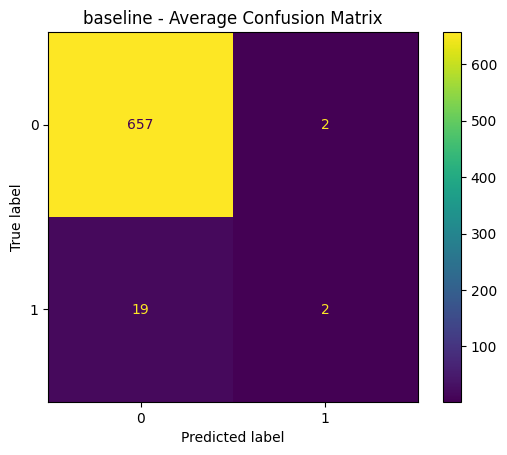

'📊 SHAP Stability (sim_M) for baseline: 0.7490'

In [ ]:
#baseline with rus and sgd as the optimizer
teacher = teacher()
teacher_skfold_trainer = Skfold_Trainer(mode='baseline', teacher=teacher, student=None, X=X_pre, y=y_pre)
teacher_skfold_trainer.train()
teacher_skfold_trainer.compute_shap_stability("baseline")